<a href="https://colab.research.google.com/github/Ericfeng84/SPP/blob/main/CaptureDemand_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#概述

这段代码构建了一个简化的服务零件（备件）供应链管理系统，主要涵盖了从需求捕获、需求预测到分销需求计划（DRP）的几个核心环节。其目标是确保在正确的时间、正确的地点有适量的零件，以满足最终客户（通过经销商）的需求，同时优化库存成本。

让我们一步步解析其业务逻辑：

1.  **基础数据定义 (构建示例数据 & 数据清洗)**
    *   **经销商与库房的绑定 (`dealer_depot_data`)**:
        *   **业务逻辑**: 每个经销商（最终需求来源）都由一个特定的“当区库房”负责供货。有些库房可能是实体库房（如 BJ, GZ），有些可能是“虚拟库房”（如 HZ\_Virtual, CQ\_Virtual）。虚拟库房通常不直接存储大量库存，而是作为一个需求汇集点，其需求会进一步传递给其实体的上级库房。
        *   **代码实现**: `dealer_depot_df` DataFrame 存储了这种映射关系。
    *   **历史订单数据 (`orders_data`)**:
        *   **业务逻辑**: 这是需求分析的基础。记录了哪个经销商在什么时间订购了多少特定零件。这是后续所有预测和计划的输入源头。
        *   **代码实现**: `orders_df` DataFrame 模拟了过去24个月各经销商对零件 'CC1223' 的订单。
    *   **库房层级与属性 (`depot_hierarchy_data`)**:
        *   **业务逻辑**: 这是多库房网络的核心。
            *   `Depot`: 库房名称。
            *   `ParentDepot`: 上级库房，定义了补货的流向。例如，BJ 库房缺货时会向 HZ 库房订货。HZ 作为顶级库房（`ParentDepot` 为 `None`），它会向外部供应商订货。
            *   `Stockiong` (应为 `Stocking`): 标记该库房是否为“库存点”（Y/N）。库存点是实际存储和管理库存的地方，需求计划主要围绕库存点进行。非库存点（如某些虚拟库房）仅传递需求。
            *   `level`: 库房在层级结构中的级别。0级为最高级（如中央仓库），级别越高，越接近需求末端。代码中对 `depot_hierarchy_df` 按 `level` 排序，这通常是为了后续按层级处理（如从低级别到高级别汇总需求，或从高级别到低级别分配库存）。
            *   `current_stock`: 当前实际库存量。
            *   `in_transit`: 在途库存，即已经订购但尚未到达的货物，通常会注明预计到达的月份和数量。这是计算净需求时的重要考量。
            *   `safety_stock`: 安全库存，为了应对需求波动或供应延迟而设定的最小库存水平。
            *   `lead_time`: 补货提前期（月），从向上级库房下订单到货物实际到达本库房所需的时间。
            *   `min_order_qty`: 最小起订量，向上级库房补货时，订单数量不能低于此值。
        *   **代码实现**: `depot_hierarchy_df` DataFrame 定义了这些属性。

2.  **构建库房层级关系 (`build_depot_hierarchy`)**
    *   **业务逻辑**: 将表格化的层级数据转换为程序更易于使用的结构，如父子关系映射、库存点集合等，方便快速查询和遍历网络。
    *   **代码实现**:
        *   `child_to_parent`: 字典，键是子库房，值是其父库房。
        *   `stocking_depots`: 集合，存储所有标记为 'Y' 的库存点名称。
        *   `hierarchy_tree`: 字典，键是父库房，值是其直接子库房列表。

3.  **需求捕获 (Capture Demand)**
    *   **将订单汇总到当区库房**:
        *   **业务逻辑**: 首先，将经销商的原始订单根据 `dealer_depot_df` 的映射，归集到其直接服务的“当区库房”。
        *   **代码实现**: `merged_df` 合并订单和经销商库房信息，然后 `depot_orders` 按零件、库房、日期汇总订单数量。
    *   **将订单向上汇总到 stocking 库房 (`find_stocking_parent`)**:
        *   **业务逻辑**: 如如果一个经销商的“当区库房”是非库存点（如虚拟库房），那么这个需求需要传递给其上级的、实际负责备货的“库存点”。例如，NZ 的需求会传递给 CQ。在这个传递过程中，我们会累加需求经过的每个库房的补货提前期。这样做的目的是将需求的时间点前移。如果下游库房需要在某个月份获得零件，考虑到层层补货的提前期，上游的 stocking 库房需要在更早的月份准备好这些零件（或者向上级订货）。
        *   **代码实现**: find_stocking_parent_with_lead_time 函数查找给定库房的最近的库存型父库房，并计算需求向上转移的总提前期。depot_orders 中的需求被更新为对应的 stocking 库房，并且需求日期根据计算出的总提前期向前推移，然后重新聚合生成 stocking_orders。这时，stocking_orders 代表了每个实际库存点所承接的原始需求，并被调整到了该库存点需要开始准备（考虑向上订货）这个需求的时间点。
    *   **汇总分库需求构建全国需求 (`rollup_to_level_0`)**:
        *   **业务逻辑**: 为了进行顶层预测或计划，需要将所有分库（库存点）的需求汇总到最高层级（Level 0）的中央仓库。这代表了整个网络的总需求。
        *   **代码实现**: `rollup_to_level_0` 函数将 `stocking_orders` 中的需求，沿着库房层级向上追溯，全部归集到0级库房（在这个例子中是 HZ），生成 `level_0_orders`。

4.  **构建全国与分库预测**
    *   **基于全国需求预测 (`forecast_demand`)**:
        *   **业务逻辑**: 使用汇总后的全国总需求（`level_0_orders`）作为历史数据，采用时间序列模型（ARIMA, SARIMAX, Holt-Winters Exponential Smoothing）来预测未来一段时间（例如6个月）的全国总需求。代码中通过比较 AICc (或 AIC) 指标来选择表现最佳的模型。
        *   **代码实现**: `forecast_demand` 函数针对特定零件和0级库房进行预测，结果存储在 `combined_forecasts`。图表部分将实际历史需求与预测结果进行了可视化对比。
    *   **分解全国预测至分库**:
        *   **业务逻辑**: 得到全国总预测后，需要将其分解到各个下级库存点。一种常用的方法是根据各分库在过去一段时间（如6个月）历史需求中所占的比例，来分配全国总预测。
        *   **代码实现**:
            *   `calculate_depot_demand_percentage`: 计算 `stocking_orders` 中每个库房过去6个月需求量占所有这些库房总需求量的百分比。
            *   `decompose_forecast`: 将 `combined_forecasts`（全国预测）按照上述计算得到的百分比，分配给每个库存点，生成 `decomposed_df`。图表部分对比了各分库的分解后预测值与实际历史需求。

5.  **DRP (Distribution Requirements Planning) 供应需求计划**
    *   **业务逻辑**: DRP 是一个核心的供应链计划过程。它从最终需求点（在这里是各个库存点的预测需求 `decomposed_df`）开始，逐级向上游库房计算净需求，并考虑库存、在途、安全库存、提前期和最小起订量等因素，最终确定每个库房何时需要向上级订多少货，以及顶级库房需要向外部供应商订多少货。
    *   **构建示例数据 (for DRP)**:
        *   `Warehouse` dataclass: 定义了DRP计算中库房所需的各种参数（当前库存、在途、安全库存、提前期、MOQ等）。
        *   `warehouses_drp`: 将 `depot_hierarchy_df` 中的库房信息实例化为 `Warehouse` 对象。
        *   `monthly_demand_for_drp`: 将 `decomposed_df`（各分库的月度预测）转换为DRP模块所需的格式：`{"库房名": [M0_demand, M1_demand, ..., M5_demand]}`。
    *   **构建DRP计算模块 (`DemandPlanner` class)**:
        *   `_build_hierarchy_map`: 构建父子库房关系。
        *   `calculate_net_demand`: 计算一个库房在特定月份的**净需求**。
            *   净需求 = 预测需求 + 安全库存补充需求 - 当前库存(仅首月) - 当月到货的在途库存。
            *   安全库存补充需求 = max(0, 安全库存目标 - 当前库存)。
        *   `aggregate_children_demand` (核心递归逻辑):
            *   这是一个关键函数，它自底向上（或说从子节点到父节点）地聚合需求。
对于一个父库房，它在某月 m 的总需求 = 它自身的净需求（在月 m） + ∑ (其所有子库房在月 m 的总需求)。
            *   注意：因为子库房的预测需求 (decomposed_df) 已经根据其从父库房的提前期进行了日期调整，所以在父库房层面聚合时，我们直接聚合子库房在月 m 的需求即可。 这与原始逻辑中父库房看子库房未来需求的做法不同，体现了需求日期已经预先调整的特性。
            *   这个函数递归调用，直到叶子节点（没有子库房的库房）。
        *   `aggregate_monthly_demand`: 计算**根库房**（如HZ中央仓库）在未来每个月需要向其**外部供应商**下订单的需求量。它调用 `aggregate_children_demand` 来得到根库房每个月需要发往其下级的总量（以及自身的直接需求），然后考虑根库房自身的补货提前期（`wh.lead_time`，即从外部供应商订货的提前期）和最小起订量（`wh.min_order_qty`）。
            *   例如，如果根库房在第3个月需要发出1000单位的货，其从供应商处的补货提前期是2个月，那么它最迟需要在第1个月（3-2）就向供应商下订单。
        *   `calculate_eoq`: 计算经济订货批量（Economic Order Quantity），一种经典的库存优化模型，用于平衡订货成本和持有成本。
        *   `generate_po_plan`: 根据计算出的月度需求和供应商的最小起订量（`supplier_moq`），生成最终的采购计划。
    *   **计算DRP**:
        *   实例化 `DemandPlanner`。
        *   调用 `planner.aggregate_monthly_demand("HZ")` 计算出中央仓库 HZ 需要在哪些月份向其上游供应商采购多少零件。
        *   计算6个月总需求，并基于此计算EOQ（这里EOQ的计算可能更多是参考性的，因为实际采购计划会按月细化并考虑MOQ）。
        *   调用 `planner.generate_po_plan` 生成最终的分月采购建议。

6.  **分库计划 Deployment (代码中未实现，但为逻辑下一步)**
    *   **业务逻辑**: DRP确定了中央仓库的采购计划。一旦货物到达中央仓库，接下来的步骤就是“部署”或“分配”（Deployment）。这涉及到如何将中央仓库的库存，按照各分库的净需求（或预测、库存状况），合理地分配和运输到各个下级库存点。这通常也会考虑运输成本、在途时间、各分库的库存目标等。
    *   **代码实现**: 此部分在提供的代码中是空的，但它是多库房库存管理的完整流程中的一个重要环节。

总结一下，这段代码的业务逻辑是：
1.  **建立供应链网络模型**：定义经销商、库房及其层级关系和属性。
2.  **需求数据整理**：将原始订单数据逐级汇总到负责备货的库存点，并进一步汇总到中央仓库。
3.  **需求预测**：在中央仓库层面进行总体需求预测，然后按历史贡献比例分解到各库存点。
4.  **供应计划 (DRP)**：从各库存点的预测需求出发，考虑库存、在途、安全库存、提前期等因素，逐级向上计算净需求，最终形成中央仓库对外部供应商的采购计划。

这个流程体现了服务零件供应链中常见的“拉动式”计划思想（需求从下游拉动上游的供应）和分层管理库存的策略。它旨在通过更精确的需求预测和计划来提高零件的可用性，同时控制整体库存水平。


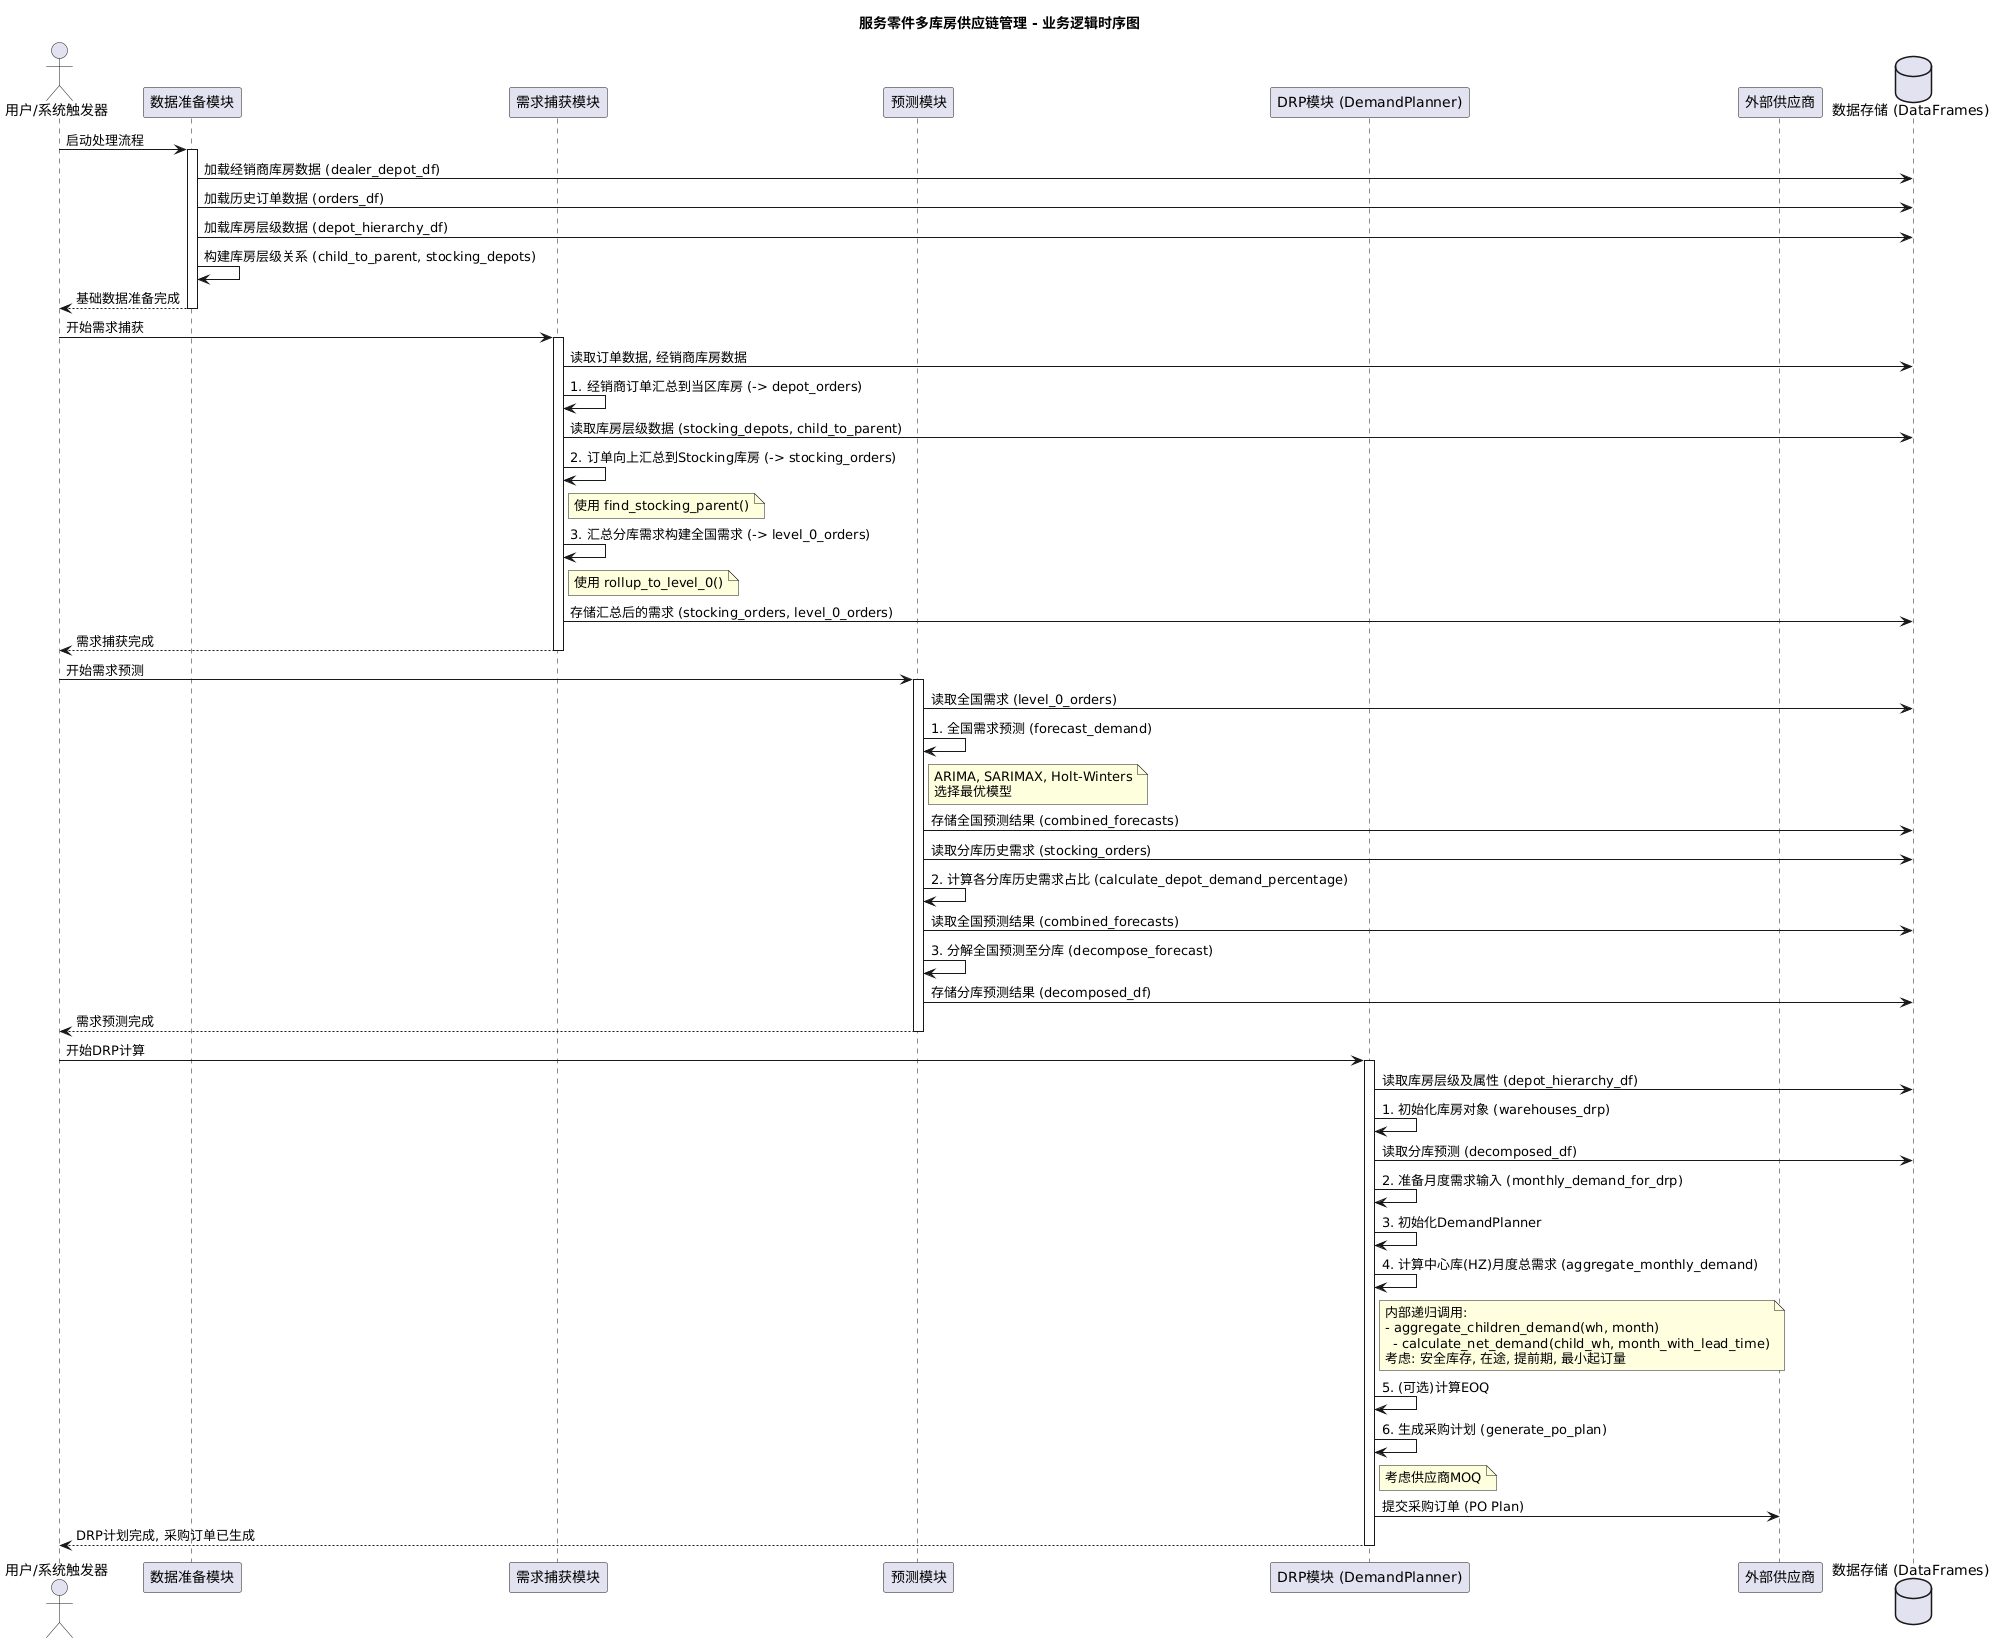

#构建示例数据

In [ ]:
# order_forecast_system.py
import pandas as pd
import numpy as np
import random
from collections import defaultdict
import os
from datetime import datetime, timedelta
from concurrent.futures import ProcessPoolExecutor
import joblib
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing # import ExponentialSmoothing
from dateutil.relativedelta import relativedelta
import math
from dataclasses import dataclass, field
from typing import Dict, List, Union, Optional
from collections import defaultdict
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

In [ ]:
# --- 经销商当区库房 ---
dealer_depot_data = {
    '库房': ['HZ_Virtual', 'HZ_Virtual', 'HZ_Virtual',
            'CQ_Virtual', 'CQ_Virtual', 'CQ_Virtual',
            'BJ', 'BJ', 'BJ',
            'GZ', 'GZ', 'GZ',
            'ZZ', 'ZZ', 'ZZ',
            'NZ', 'NZ', 'NZ'],
    '经销商代码': ['A1011', 'A1012', 'A1013',  # HZ dealers（与虚拟库房绑定）
                'A1016', 'A1017', 'A1018',  # CQ dealers（与虚拟库房绑定）
                'A1022', 'A1023', 'A1024',  # BJ dealers
                'A1028', 'A1029', 'A1030',  # GZ dealers
                'A1033', 'A1034', 'A1035',  # ZZ dealers
                'A1036', 'A1037', 'A1038']  # NZ dealers
}

# --- 产生需求数据 ---
start_date = datetime(2023, 1, 1)  # Example start date
num_months = 24
orders_data = {
    '零件号': [],
    '经销商代码': [],
    '数量': [],
    '日期': []
}

# 向量化随机赋值每月经销商销量
dealers = np.repeat(dealer_depot_data['经销商代码'], num_months)
months = np.tile(range(num_months), len(dealer_depot_data['经销商代码']))
dates = [start_date + relativedelta(months=m) for m in months]
quantities = 100 + np.random.randint(0, 50, size=len(dealers)) #随机需求 100-150

orders_data = {
    '零件号': ['CC1223'] * len(dealers),
    '经销商代码': dealers,
    '数量': quantities,
    '日期': dates
}

# 库房数据-BOD
depot_hierarchy_data = {
    'Depot': ['HZ', 'HZ_Virtual','CQ', 'CQ_Virtual','BJ', 'GZ', 'ZZ', 'NZ'],
    'ParentDepot': [None, 'HZ','HZ', 'CQ','HZ', 'HZ', 'HZ', 'CQ'],
    'Stockiong': ['Y', 'Y','Y', 'Y', 'Y','Y', 'Y', 'N'],
    'level': [0, 1,1,2,1,1, 1, 2],
    'current_stock': [213, 0,158,0,32,71, 8, 3] ,               # 当前库存
    'in_transit':  [{}, {},{0: 50},{},{},{}, {}, {} ],          # 在途库存（格式：{第n月到货: 数量}）
    'safety_stock': [500, 0,100,0,100,80, 80, 80],              # 安全库存
    'lead_time': [3, 0,0.5,0,1,1, 1, 1],                          # 补货周期（单位：月），不支持小数，需要迭代
    'min_order_qty': [1, 1,1,1,1,1, 1, 1],                      # 最小起订量 (for replenishing this warehouse)
    'backorders': [0, 5, 10, 0, 2,0,0,0]                        # 欠货
}

#将数据放入DataFram并进行数据清洗
orders_df = pd.DataFrame(orders_data)
dealer_depot_df = pd.DataFrame(dealer_depot_data)
depot_hierarchy_df = pd.DataFrame(depot_hierarchy_data)


#数据清洗

In [ ]:
# prompt: 将depot_hierarchy_data 按照Level 排序
depot_hierarchy_df = depot_hierarchy_df.sort_values(by='level')



##示例数据

In [ ]:
dealer_depot_df

,库房,经销商代码
0,HZ_Virtual,A1011
1,HZ_Virtual,A1012
2,HZ_Virtual,A1013
3,CQ_Virtual,A1016
4,CQ_Virtual,A1017
5,CQ_Virtual,A1018
6,BJ,A1022
7,BJ,A1023
8,BJ,A1024
9,GZ,A1028


In [ ]:
orders_df

,零件号,经销商代码,数量,日期
0,CC1223,A1011,128,2023-01-01
1,CC1223,A1011,141,2023-02-01
2,CC1223,A1011,136,2023-03-01
3,CC1223,A1011,116,2023-04-01
4,CC1223,A1011,111,2023-05-01
...,...,...,...,...
427,CC1223,A1038,123,2024-08-01
428,CC1223,A1038,120,2024-09-01
429,CC1223,A1038,135,2024-10-01
430,CC1223,A1038,146,2024-11-01


In [ ]:
depot_hierarchy_df

,Depot,ParentDepot,Stockiong,level,current_stock,in_transit,safety_stock,lead_time,min_order_qty,backorders
0,HZ,None,Y,0,213,{},500,3.0,1,0
1,HZ_Virtual,HZ,Y,1,0,{},0,0.0,1,5
2,CQ,HZ,Y,1,158,{0: 50},100,0.5,1,10
4,BJ,HZ,Y,1,32,{},100,1.0,1,2
6,ZZ,HZ,Y,1,8,{},80,1.0,1,0
5,GZ,HZ,Y,1,71,{},80,1.0,1,0
3,CQ_Virtual,CQ,Y,2,0,{},0,0.0,1,0
7,NZ,CQ,N,2,3,{},80,1.0,1,0


##构建库房层级关系

In [ ]:
def build_depot_hierarchy(depot_hierarchy_df):
    """构建库房层级关系字典，优化层级查询"""


    # 构建子库房到父库房的映射
    child_to_parent = {}
    # 标记哪些库房是stocking库房
    stocking_depots = set()
    # 构建层级关系树
    hierarchy_tree = defaultdict(list)

    for _, row in depot_hierarchy_df.iterrows():
        child = row['Depot']
        parent = row['ParentDepot']
        stocking = row['Stockiong']

        child_to_parent[child] = parent
        if stocking == 'Y':
            stocking_depots.add(child)

        if parent is not None:
            hierarchy_tree[parent].append(child)
    return child_to_parent, stocking_depots, hierarchy_tree

In [ ]:
child_to_parent, stocking_depots, hierarchy_tree = build_depot_hierarchy(depot_hierarchy_df)

In [ ]:
child_to_parent

{'HZ': None,
 'HZ_Virtual': 'HZ',
 'CQ': 'HZ',
 'BJ': 'HZ',
 'ZZ': 'HZ',
 'GZ': 'HZ',
 'CQ_Virtual': 'CQ',
 'NZ': 'CQ'}

In [ ]:
stocking_depots

{'BJ', 'CQ', 'CQ_Virtual', 'GZ', 'HZ', 'HZ_Virtual', 'ZZ'}

In [ ]:
hierarchy_tree

defaultdict(list,
            {'HZ': ['HZ_Virtual', 'CQ', 'BJ', 'ZZ', 'GZ'],
             'CQ': ['CQ_Virtual', 'NZ']})

#获取需求 Capture Demand

##将订单汇总到当区库房

In [ ]:

# 1. 将经销商订单与库房关联
merged_df = pd.merge(orders_df, dealer_depot_df, on='经销商代码', how='left')
# 2. 按零件号、库房和日期汇总数量
depot_orders = merged_df.groupby(['零件号', '库房', '日期'])['数量'].sum().reset_index()
depot_orders

,零件号,库房,日期,数量
0,CC1223,BJ,2023-01-01,347
1,CC1223,BJ,2023-02-01,351
2,CC1223,BJ,2023-03-01,337
3,CC1223,BJ,2023-04-01,418
4,CC1223,BJ,2023-05-01,404
...,...,...,...,...
139,CC1223,ZZ,2024-08-01,339
140,CC1223,ZZ,2024-09-01,368
141,CC1223,ZZ,2024-10-01,412
142,CC1223,ZZ,2024-11-01,383


In [ ]:
# prompt: 汇总数量列的数量

# 计算总数量
total_quantity = depot_orders['数量'].sum()
print(f"总数量: {total_quantity}")


总数量: 53616


## 寻找Stocking库房


In [ ]:
# Modified function to find stocking parent and calculate the "effective" month of demand for the parent
def find_stocking_parent_with_lead_time(depot, child_to_parent, stocking_depots, depot_lead_times):
    """
    查找给定库房的最近stocking父库房，并考虑提前期计算需求转移到的月份。
    返回 (stocking_parent, effective_month_delta)
    effective_month_delta 是相对于原始需求月份的月份偏移量。
    """
    current = depot
    months_shifted = 0 # 记录需求向上转移的总月数

    # 如果当前库房就是stocking库房，直接返回
    if current in stocking_depots:
        return current, 0 # 提前期为0

    # 否则向上查找直到找到stocking库房
    while current in child_to_parent:
        parent = child_to_parent[current]
        if parent is None:
            return None, None # 没有找到stocking父库房

        # 获取当前库房从其父库房补货的提前期
        # 需要确保 depot_lead_times 字典包含了所有库房的 lead_time
        lead_time = depot_lead_times.get(current, 0)
        months_shifted += lead_time

        current = parent # 向上移动到父库房

        if current in stocking_depots:
            return current, months_shifted # 找到stocking父库房，返回其名称和总提前期

    return None, None # 如果循环结束还没有找到，理论上不应该发生如果层级定义正确

# Build a dictionary of depot lead times for quick lookup
depot_lead_times = depot_hierarchy_df.set_index('Depot')['lead_time'].to_dict()

# Apply the modified function and store both stocking depot and month shift
# We apply the function to each row, not just the '库房' column, to get both return values,like (BJ, 0)
stocking_info = depot_orders.apply(
    lambda row: find_stocking_parent_with_lead_time(
        row['库房'], child_to_parent, stocking_depots, depot_lead_times
    ), axis=1
)

# Split the results into new columns
depot_orders['StockingDepot'] = stocking_info.apply(lambda x: x[0])
depot_orders['MonthShift'] = stocking_info.apply(lambda x: x[1])

# Calculate the effective date for the stocking depot
# Shift the date backward by MonthShift months
depot_orders['EffectiveDate'] = depot_orders.apply(
    lambda row: row['日期'] - relativedelta(months=row['MonthShift']) if row['StockingDepot'] is not None else None,
    axis=1
)
depot_orders

,零件号,库房,日期,数量,StockingDepot,MonthShift,EffectiveDate
0,CC1223,BJ,2023-01-01,347,BJ,0.0,2023-01-01
1,CC1223,BJ,2023-02-01,351,BJ,0.0,2023-02-01
2,CC1223,BJ,2023-03-01,337,BJ,0.0,2023-03-01
3,CC1223,BJ,2023-04-01,418,BJ,0.0,2023-04-01
4,CC1223,BJ,2023-05-01,404,BJ,0.0,2023-05-01
...,...,...,...,...,...,...,...
139,CC1223,ZZ,2024-08-01,339,ZZ,0.0,2024-08-01
140,CC1223,ZZ,2024-09-01,368,ZZ,0.0,2024-09-01
141,CC1223,ZZ,2024-10-01,412,ZZ,0.0,2024-10-01
142,CC1223,ZZ,2024-11-01,383,ZZ,0.0,2024-11-01


##将订单向上汇总到stocking库房

In [ ]:
# Filter out rows where no stocking depot was found (if any)
stocking_orders_with_shifted_dates = depot_orders[depot_orders['StockingDepot'].notna()]

# Group by stocking depot and the effective date, and sum the quantities
stocking_orders = stocking_orders_with_shifted_dates.groupby(
    ['零件号', 'StockingDepot', 'EffectiveDate']
)['数量'].sum().reset_index()

# Rename the columns to be consistent with the original stocking_orders output structure
stocking_orders = stocking_orders.rename(columns={'StockingDepot': '库房', 'EffectiveDate': '日期'})

# Sort by date for better readability
stocking_orders = stocking_orders.sort_values(by=['库房', '日期']).reset_index(drop=True)

# 打印汇总后的数据 (包含提前期考虑)
print("Stocking orders with lead time consideration:")
stocking_orders

Stocking orders with lead time consideration:


,零件号,库房,日期,数量
0,CC1223,BJ,2023-01-01,347
1,CC1223,BJ,2023-02-01,351
2,CC1223,BJ,2023-03-01,337
3,CC1223,BJ,2023-04-01,418
4,CC1223,BJ,2023-05-01,404
...,...,...,...,...
139,CC1223,ZZ,2024-08-01,339
140,CC1223,ZZ,2024-09-01,368
141,CC1223,ZZ,2024-10-01,412
142,CC1223,ZZ,2024-11-01,383


##汇总分库需求构建全国需求

In [ ]:
# prompt: 按月把需求汇总到level=0最高层级的库房

import pandas as pd
def rollup_to_level_0(stocking_orders, depot_hierarchy_df):
    """将订单汇总到level=0的最高层级库房"""

    # 构建库房层级关系
    child_to_parent = {}
    for _, row in depot_hierarchy_df.iterrows():
        child_to_parent[row['Depot']] = row['ParentDepot']

    # 查找level=0的库房
    level_0_depots = depot_hierarchy_df[depot_hierarchy_df['level'] == 0]['Depot'].tolist()

    # 创建结果DataFrame
    result_data = []
    # 处理每个库房的订单
    for _, row in stocking_orders.iterrows():
        part_no = row['零件号']
        depot = row['库房']
        date = row['日期']
        qty = row['数量']

        # 找到level=0的父库房
        current_depot = depot
        while current_depot is not None and current_depot not in level_0_depots:
          current_depot = child_to_parent.get(current_depot)

        if current_depot in level_0_depots:
            result_data.append({
                '零件号': part_no,
                '库房': current_depot,
                '日期': date,
                '数量': qty
            })
        else:
            #处理找不到level=0的情况，可以记录日志或抛出异常
            print(f"Warning: Depot {depot} does not have a level=0 parent depot.")
            # 可以选择忽略或者执行其他操作

    result_df = pd.DataFrame(result_data)

    # 按零件号、库房和日期汇总数量
    level_0_orders = result_df.groupby(['零件号', '库房', '日期'])['数量'].sum().reset_index()
    return level_0_orders

level_0_orders = rollup_to_level_0(stocking_orders, depot_hierarchy_df)
level_0_orders


,零件号,库房,日期,数量
0,CC1223,HZ,2022-12-01,364
1,CC1223,HZ,2023-01-01,2200
2,CC1223,HZ,2023-02-01,2187
3,CC1223,HZ,2023-03-01,2136
4,CC1223,HZ,2023-04-01,2343
5,CC1223,HZ,2023-05-01,2142
6,CC1223,HZ,2023-06-01,2190
7,CC1223,HZ,2023-07-01,2237
8,CC1223,HZ,2023-08-01,2310
9,CC1223,HZ,2023-09-01,2350


In [ ]:
#算法2，使用Pandas 实现
"""
In general, the vectorized approach using Pandas functions like .apply(), .groupby(), and .sum() will be significantly more efficient than iterating through rows with a Python for loop, especially for larger datasets.

Here's why:

Vectorization: Pandas and NumPy operations are designed to work on entire arrays or Series (vectors) at once, rather than processing elements one by one. These operations are implemented in highly optimized code (often in C or Fortran), allowing them to perform computations on many data points simultaneously.
Overhead of Python Loops: Explicit Python for loops involve significant overhead for interpreting and executing the code for each iteration. This becomes a bottleneck when dealing with thousands or millions of rows.
Pandas Optimizations: Pandas is built on top of NumPy and includes its own internal optimizations for common data manipulation tasks like filtering, grouping, and aggregation.
Analogy:

Think of it like moving a large pile of bricks:

for loop: You pick up one brick at a time and move it.
Vectorized Pandas: You use a forklift or a wheelbarrow to move many bricks at once.
In the context of your code:

The for loop in the original rollup_to_level_0 function iterates through each individual order in the stocking_orders DataFrame. Inside the loop, it performs operations on a single row at a time.

The vectorized approach (as described in the previous response) would perform the hierarchy traversal and aggregation much more quickly because it would be processed by optimized C code under the hood of Pandas and NumPy, rather than stepping through each row with Python's interpreter.

Conclusion:

For data manipulation in Pandas, vectorized operations are almost always more efficient than explicit Python for loops. While for loops can be easier to understand for simple tasks or when the logic is complex and hard to vectorize, they should be avoided when performance is critical, especially with large datasets.

The vectorized approach aligns with the common data science practice of utilizing libraries like Pandas and NumPy for performance gains [1].
"""



import pandas as pd
def rollup_to_level_0(stocking_orders, depot_hierarchy_df):
    """Aggregates orders up to the highest level (level=0) warehouse."""

    # Build a series mapping child depots to their immediate parent depot
    child_to_parent_series = depot_hierarchy_df.set_index('Depot')['ParentDepot']

    # Identify level 0 depots
    level_0_depots = depot_hierarchy_df[depot_hierarchy_df['level'] == 0]['Depot'].tolist()

    # Create a copy to avoid modifying the original DataFrame
    rolled_up_df = stocking_orders.copy()

    # Add a column for the current depot in the rollup process.
    # Initially, this is the stocking depot from stocking_orders.
    rolled_up_df['CurrentDepot'] = rolled_up_df['库房'] # Assuming '库房' is the stocking depot column

    # Apply the rollup logic using a function that traverses the hierarchy.
    # This function will find the level 0 parent for each depot.
    def find_level_0_parent(depot, child_to_parent_series, level_0_depots):
        current = depot
        while current is not None and current not in level_0_depots:
            # Use .get() with default None for depots not in the series
            current = child_to_parent_series.get(current)
        return current

    # Apply the hierarchy traversal function to find the Level 0 parent for each row
    rolled_up_df['Level0Depot'] = rolled_up_df['CurrentDepot'].apply(
        lambda x: find_level_0_parent(x, child_to_parent_series, level_0_depots)
    )

    # Filter out any rows where a Level 0 parent was not found (if applicable)
    rolled_up_df = rolled_up_df[rolled_up_df['Level0Depot'].notna()].copy()

    # Group by Part Number, the identified Level 0 Depot, and Date, then sum the Quantity
    level_0_orders = rolled_up_df.groupby(['零件号', 'Level0Depot', '日期'])['数量'].sum().reset_index()

    # Rename the Level 0 Depot column to match the original '库房' column name for consistency
    level_0_orders = level_0_orders.rename(columns={'Level0Depot': '库房'})

    return level_0_orders

level_0_orders = rollup_to_level_0(stocking_orders, depot_hierarchy_df)
level_0_orders

,零件号,库房,日期,数量
0,CC1223,HZ,2022-12-01,364
1,CC1223,HZ,2023-01-01,2200
2,CC1223,HZ,2023-02-01,2187
3,CC1223,HZ,2023-03-01,2136
4,CC1223,HZ,2023-04-01,2343
5,CC1223,HZ,2023-05-01,2142
6,CC1223,HZ,2023-06-01,2190
7,CC1223,HZ,2023-07-01,2237
8,CC1223,HZ,2023-08-01,2310
9,CC1223,HZ,2023-09-01,2350


#构建全国与分库预测

##基于全国需求预测

Processing forecast for Part: CC1223, Depot: HZ

Checking stationarity for CC1223 at HZ...
Series is constant or has insufficient variation. Treating as stationary.
Determined differencing order (d) = 0
Plotting ACF and PACF for CC1223 at HZ after 0 difference(s)...


<ipython-input-21-e0ac077fb8b8>:136: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data = data.asfreq('M', fill_value=0) # Explicitly fill with 0 for missing months
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1490: ValueWarning: Matrix is singular. Using pinv.
  warnings.warn("Matrix is singular. Using pinv.", ValueWarning)


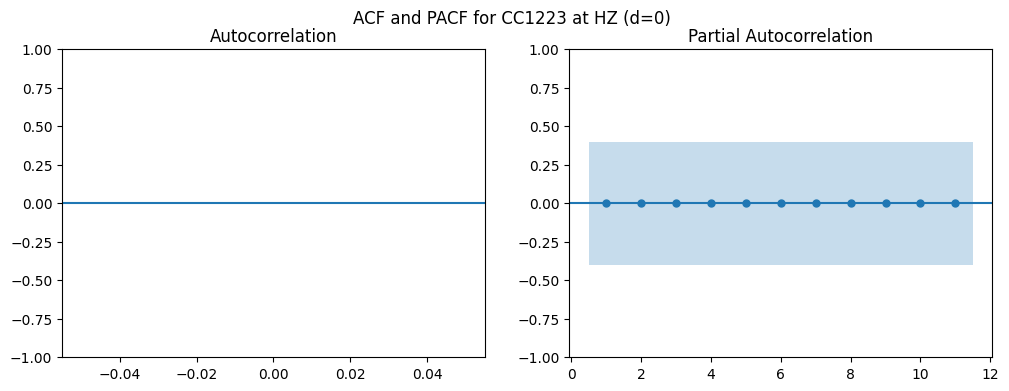

Performing simplified parameter selection...
Selected non-seasonal ARIMA parameters (p, d, q): (0, 0, 0) based on AIC.
Time series for CC1223 at HZ is constant. Forecasting with the constant value.

--- Combined Forecasts ---


<ipython-input-21-e0ac077fb8b8>:243: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=y.index[-1] + pd.DateOffset(months=1), periods=forecast_horizon, freq='M')


,日期,Predictions,零件号,库房
0,2024-12-31,0,CC1223,HZ
1,2025-01-31,0,CC1223,HZ
2,2025-02-28,0,CC1223,HZ
3,2025-03-31,0,CC1223,HZ
4,2025-04-30,0,CC1223,HZ
5,2025-05-31,0,CC1223,HZ


In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings





def check_and_difference_stationarity(series, significance_level=0.05, max_diff=2):
    """
    Checks for stationarity using the ADF test and differences the series
    if necessary, up to a maximum number of differences.

    Args:
        series: Pandas Series representing the time series data.
        significance_level: The significance level for the ADF test (alpha).
        max_diff: Maximum number of differences to apply.

    Returns:
        tuple: (differenced_series, d_order)
               differenced_series is the series after differencing.
               d_order is the number of differences applied.
               Returns (original_series, 0) if stationary or max_diff reached
               or if the series is constant.
    """
    d_order = 0
    tested_series = series.copy()

    # Check if the series is constant after dropping NaNs
    if tested_series.dropna().nunique() <= 1:
        print("Series is constant or has insufficient variation. Treating as stationary.")
        return series, 0 # Constant series is considered stationary with d=0

    for i in range(max_diff + 1):
        # Perform ADF test
        # adfuller requires at least 8 observations by default for p-value calculation
        if len(tested_series.dropna()) < 8:
             print(f"Warning: Not enough non-NaN data points ({len(tested_series.dropna())}) for ADF test at {i} difference(s). Skipping test.")
             # If not enough data, cannot confirm stationarity, might need differencing depending on domain knowledge
             # For simplicity, we'll stop differencing if we don't have enough data to test
             return series, 0 if i == 0 else i - 1 # Return original or last differenced series

        adf_test = adfuller(tested_series.dropna()) # .dropna() handles NaN introduced by differencing
        p_value = adf_test[1]

        print(f"ADF test p-value at {i} difference(s): {p_value}")

        if p_value < significance_level:
            print(f"Series is stationary after {i} difference(s).")
            return tested_series, i
        else:
            if i < max_diff:
                print(f"Series is non-stationary, applying {i+1} difference(s)...")
                tested_series = series.diff(i+1).dropna() # Apply next level of differencing
                d_order = i + 1
            else:
                print(f"Series is still non-stationary after {max_diff} difference(s). Cannot achieve stationarity within max_diff.")
                return tested_series, d_order # Return the last differenced series and order

    return series, 0 # Should not reach here if max_diff >= 0, but as a fallback


def forecast_demand_with_stationarity(df, part_no, depot, forecast_horizon=6):
    """
    Forecasts demand using multiple models, checks stationarity for ARIMA/SARIMAX,
    applies differencing if necessary, and selects the best model based on AICc.

    Args:
        df: DataFrame containing historical demand data.
        part_no: Part number.
        depot: Depot.
        forecast_horizon: Number of months to forecast.

    Returns:
        DataFrame: Predictions from the best model.
    """

    #Filter data for the specified part and depot
    data = df[(df['零件号'] == part_no) & (df['库房'] == depot)].copy()

    # Convert date to datetime objects and set as index
    data['日期'] = pd.to_datetime(data['日期'])
    data.set_index('日期', inplace=True)

    # Ensure monthly frequency and fill missing values
    # Use `fillna(0)` if missing months should be treated as zero demand
    # Or use interpolation methods if appropriate for your data
    data = data.asfreq('M', fill_value=0) # Explicitly fill with 0 for missing months
    # If using fill_value=0, subsequent fillna(method='bfill').fillna(method='ffill') might not be necessary
    # data = data.fillna(method='bfill').fillna(method='ffill') # Keep if non-zero interpolation is desired

    # Prepare data for models
    y = data['数量']

    # Ensure there is enough data for forecasting
    # Increased the minimum data points required for meaningful time series forecasting
    if len(y) < 12: # Example threshold: need at least 1 year of data
        print(f"Warning: Not enough historical data ({len(y)} months) for {part_no} at {depot} for reliable forecasting. Skipping.")
        return pd.DataFrame()

    # --- Stationarity check and differencing ---
    print(f"\nChecking stationarity for {part_no} at {depot}...")
    y_stationary, d_order = check_and_difference_stationarity(y)
    print(f"Determined differencing order (d) = {d_order}")

    # Plot ACF and PACF of the (potentially differenced) series
    # Only plot if there are enough data points after differencing
    if len(y_stationary.dropna()) >= 2: # Need at least 2 points to calculate ACF/PACF
        print(f"Plotting ACF and PACF for {part_no} at {depot} after {d_order} difference(s)...")
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        # FIX: Add zero=False to exclude lag 0 from plotting
        # Adjust lags based on data length, max 24 or half the data points
        nobs = len(y_stationary.dropna())
        lags_to_plot = min(24, nobs // 2 -1) if nobs > 1 else 0

        if lags_to_plot > 0:
            plot_acf(y_stationary.dropna(), ax=axes[0], lags=lags_to_plot, zero=False) # Plot up to available lags, exclude lag 0
            plot_pacf(y_stationary.dropna(), ax=axes[1], lags=lags_to_plot, zero=False) # Plot up to available lags, exclude lag 0
            plt.suptitle(f'ACF and PACF for {part_no} at {depot} (d={d_order})')
            plt.show()
        else:
             print("Not enough data points after differencing to plot ACF/PACF.")

    else:
        print("Not enough data points after differencing to plot ACF/PACF.")


    # --- Automated Parameter Selection (Example Grid Search) ---
    # This is a simplified example. A more robust approach would use
    # auto_arima from pmdarima or more sophisticated methods.
    print("Performing simplified parameter selection...")
    best_p = 0
    best_q = 0
    best_aic_for_pq = float('inf')

    # Define a range for p and q to search (adjust based on data characteristics/ACF/PACF)
    # Reduce the search space if data is limited
    max_pq = min(5, int(len(y.dropna()) / 4)) # Simple heuristic
    p_range = range(0, max_pq + 1)
    q_range = range(0, max_pq + 1)


    # Note: For SARIMAX, you'd also need to search for seasonal parameters (P, D, Q, S)
    # This example focuses on non-seasonal p and q for simplicity,
    # but the d is automatically determined.

    warnings.filterwarnings("ignore") # Suppress warnings during grid search
    for p in p_range:
        for q in q_range:
            try:
                # Use the original series (y) and let ARIMA/SARIMAX handle differencing internally
                # Or use the differenced series (y_stationary) with d=0 if manual differencing is preferred for analysis
                # Using original series with determined d is common practice for model fitting
                # Ensure the series is not empty or all NaNs
                if y.dropna().empty:
                    continue

                # ARIMA model requires at least d+p+q observations for fitting
                if len(y.dropna()) < d_order + p + q + 1:
                     # print(f"Skipping ARIMA({p},{d_order},{q}) due to insufficient data length.")
                     continue

                model = ARIMA(y.dropna(), order=(p, d_order, q))
                # Check for convergence issues during fit
                model_fit = model.fit()

                # Check for convergence status if available (depends on statsmodels version)
                # if not hasattr(model_fit, 'mle_retvals') or 'converged' not in model_fit.mle_retvals or not model_fit.mle_retvals['converged']:
                #     print(f"Warning: ARIMA({p},{d_order},{q}) for {part_no}, {depot} did not converge.")
                #     continue

                if model_fit.aic < best_aic_for_pq:
                    best_aic_for_pq = model_fit.aic
                    best_p = p
                    best_q = q
            except Exception as e:
                 # print(f"ARIMA({p},{d_order},{q}) fitting failed for {part_no}, {depot}: {e}")
                continue # Skip if model fitting fails for these parameters

    print(f"Selected non-seasonal ARIMA parameters (p, d, q): ({best_p}, {d_order}, {best_q}) based on AIC.")
    warnings.filterwarnings("default") # Restore warnings

    # --- Models with potentially optimized parameters ---
    models = []

    # Ensure the series is not empty or all NaNs before fitting models
    if y.dropna().empty:
        print(f"Error: Time series data for {part_no} at {depot} is empty or all NaNs after cleaning. Cannot fit models.")
        return pd.DataFrame()

    # Handle the case of constant series separately for forecasting
    if y.dropna().nunique() <= 1:
         print(f"Time series for {part_no} at {depot} is constant. Forecasting with the constant value.")
         constant_value = y.dropna().iloc[0]
         future_dates = pd.date_range(start=y.index[-1] + pd.DateOffset(months=1), periods=forecast_horizon, freq='M')
         forecast_df = pd.DataFrame({'Predictions': constant_value}, index=future_dates)
         forecast_df['零件号'] = part_no
         forecast_df['库房'] = depot
         return forecast_df


    try:
      # ARIMA using selected parameters
      # Ensure enough data points are available for the chosen order
      if len(y.dropna()) >= d_order + best_p + best_q + 1:
        model_arima = ARIMA(y.dropna(), order=(best_p, d_order, best_q)).fit()
        models.append(('ARIMA', model_arima))
      else:
         print(f"Skipping ARIMA for {part_no}, {depot} due to insufficient data length for order ({best_p}, {d_order}, {best_q}).")

    except Exception as e:
        print(f"ARIMA failed for {part_no}, {depot} with order ({best_p}, {d_order}, {best_q}): {e}")

    try:
        # SARIMAX - Use determined d_order for non-seasonal differencing.
        # Seasonal parameters (1, 1, 1, 12) are examples and ideally should also be optimized.
        # Use .dropna() to avoid issues with fitting on series with NaNs
        # SARIMAX also has minimum data length requirements depending on order
        # A rough estimate for SARIMAX data requirement: seasonal_period * D + d + p + q + P + Q + 1
        seasonal_period = 12 # from seasonal_order(1, 1, 1, 12)
        seasonal_D = 1
        seasonal_P = 1
        seasonal_Q = 1
        min_sarimax_len = seasonal_period * seasonal_D + d_order + best_p + best_q + seasonal_P + seasonal_Q + 1

        if len(y.dropna()) >= min_sarimax_len:
            model_sarimax = SARIMAX(y.dropna(), order=(best_p, d_order, best_q), seasonal_order=(seasonal_P, seasonal_D, seasonal_Q, seasonal_period)).fit(disp=False)
            models.append(('SARIMAX', model_sarimax))
        else:
            print(f"Skipping SARIMAX for {part_no}, {depot} due to insufficient data length ({len(y.dropna())}) for order ({best_p}, {d_order}, {best_q})x({seasonal_P},{seasonal_D},{seasonal_Q},{seasonal_period}). Requires at least {min_sarimax_len} data points.")

    except Exception as e:
        print(f"SARIMAX failed for {part_no}, {depot} with order ({best_p}, {d_order}, {best_q})x(1,1,1,12): {e}")

    try:
        # Holt-Winters (does not use differencing or p/q/d parameters)
        # Use .dropna() to avoid issues with fitting on series with NaNs
        # Holt-Winters can sometimes handle NaNs, but it's safer to pass clean data
        # Holt-Winters requires at least seasonal_periods observations for seasonal models
        seasonal_period_hw = 12 # from seasonal='add', seasonal_periods=12
        if len(y.dropna()) >= seasonal_period_hw:
            model_hw = ExponentialSmoothing(y.dropna(), trend='add', seasonal='add', seasonal_periods=seasonal_period_hw).fit()
            models.append(('Holt-Winters', model_hw))
        else:
             print(f"Skipping Holt-Winters for {part_no}, {depot} due to insufficient data length ({len(y.dropna())}) for seasonal period {seasonal_period_hw}.")

    except Exception as e:
        print(f"Holt-Winters failed for {part_no}, {depot}: {e}")


    if len(models) == 0:
        print(f"No model could be trained for {part_no}, {depot}")
        return pd.DataFrame()

    # Forecast and select best model based on AICc
    best_model_predictions = None # Renamed to avoid conflict with model object
    best_criterion_value = float('inf') # Use best_criterion_value for either AICc or AIC
    best_model_name = None
    used_criterion = None # Track which criterion (AICc or AIC) was used

    for name, model in models:
        try:
            if name in ['ARIMA','SARIMAX']:
                # Ensure start and end dates for prediction are handled correctly
                # get_forecast takes steps or start/end indices
                # Use steps for forecasting future
                predictions = model.get_forecast(steps=forecast_horizon).predicted_mean
            else:
                # Holt-Winters forecast method takes steps directly
                predictions = model.forecast(forecast_horizon)

            # Use AICc for model selection if available, otherwise use AIC
            current_criterion_value = float('inf')
            if hasattr(model,'aicc'):
                current_criterion_value = model.aicc
                used_criterion = 'AICc'
            elif hasattr(model,'aic'): # Fallback to AIC
                 current_criterion_value = model.aic
                 used_criterion = 'AIC'
                 # print(f"Note: Using AIC for {name} model selection as AICc is not available.") # Can be noisy

            if current_criterion_value < best_criterion_value:
                best_criterion_value = current_criterion_value
                best_model_predictions = predictions # Store predictions, not the model object
                best_model_name = name
        except Exception as e:
          print(f"Prediction failed for model {name} for {part_no}, {depot}: {e}")

    if best_model_predictions is None: # Check if any predictions were successful
        print(f"No successful predictions for {part_no}, {depot}")
        return pd.DataFrame()

    print(f"Best model selected based on {used_criterion}: {best_model_name} with {used_criterion}: {best_criterion_value:.2f}")

    #Add index and columns to the best forecast
    # The index of the predictions Series should already be the future dates if steps was used
    # If not, calculate future dates
    if not isinstance(best_model_predictions.index, pd.DatetimeIndex) or len(best_model_predictions.index) != forecast_horizon:
        future_dates = pd.date_range(start=y.index[-1] + pd.DateOffset(months=1), periods=forecast_horizon, freq='M')
        forecast_df = pd.DataFrame({'Predictions': best_model_predictions.values}) # Use values if index is not dates
        forecast_df.index = future_dates
    else:
        forecast_df = pd.DataFrame({'Predictions': best_model_predictions}) # Use series directly if index is dates

    # Ensure predictions are non-negative as demand cannot be negative
    forecast_df['Predictions'] = forecast_df['Predictions'].clip(lower=0)

    forecast_df['零件号'] = part_no
    forecast_df['库房'] = depot


    return forecast_df

# Example usage with the modified function
forecasts = []
# Assuming level_0_orders is available from the previous cell
# Ensure level_0_orders is not empty before proceeding
if level_0_orders.empty:
    print("Error: level_0_orders DataFrame is empty. Cannot proceed with forecasting.")
else:
    for part in level_0_orders['零件号'].unique():
        for depot in level_0_orders['库房'].unique():
            print(f"Processing forecast for Part: {part}, Depot: {depot}")
            # Pass the potentially constant series to the function
            forecast = forecast_demand_with_stationarity(level_0_orders, part, depot)
            if not forecast.empty:
                forecasts.append(forecast)

# Combine all forecasts into a single DataFrame
if forecasts: # Check if the list is not empty
    combined_forecasts = pd.concat(forecasts)
    combined_forecasts.reset_index(inplace=True) # Reset index to make '日期' a column
    combined_forecasts.rename(columns={'index': '日期'}, inplace=True) # Rename the index column
    print("\n--- Combined Forecasts ---")
    display(combined_forecasts)
else:
    print("\nNo forecasts were successfully generated.")

In [ ]:
# prompt: 采用时间序列模型，优选最佳预测方式预测未来6个月的需求


import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

def forecast_demand(df, part_no, depot, forecast_horizon=6):
    """
    Forecasts demand using multiple models and selects the best based on AICc.

    Args:
        df: DataFrame containing historical demand data.
        part_no: Part number.
        depot: Depot.
        forecast_horizon: Number of months to forecast.

    Returns:
        DataFrame: Predictions from the best model.
    """

    #Filter data for the specified part and depot
    data = df[(df['零件号'] == part_no) & (df['库房'] == depot)].copy()

    # Convert date to datetime objects and set as index
    data['日期'] = pd.to_datetime(data['日期'])
    data.set_index('日期', inplace=True)
    data = data.asfreq('M', method='ffill') # Ensure monthly frequency

    # Prepare data for models
    y = data['数量']

    #Models
    models = []

    try:
      # ARIMA
      model_arima = ARIMA(y, order=(5, 1, 0)).fit()  # Example order
      models.append(('ARIMA', model_arima))
    except Exception as e:
        print(f"ARIMA failed for {part_no}, {depot}: {e}")


    try:
        #SARIMAX
        model_sarimax = SARIMAX(y, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit(disp=False) # Example orders
        models.append(('SARIMAX', model_sarimax))
    except Exception as e:
        print(f"SARIMAX failed for {part_no}, {depot}: {e}")

    try:
        # Holt-Winters
        model_hw = ExponentialSmoothing(y, trend='add', seasonal='add', seasonal_periods=12).fit()
        models.append(('Holt-Winters', model_hw))
    except Exception as e:
        print(f"Holt-Winters failed for {part_no}, {depot}: {e}")

    if len(models) == 0:
        print(f"No model could be trained for {part_no}, {depot}")
        return pd.DataFrame()

    # Forecast and select best model
    best_model = None
    best_aicc = float('inf')  # Initialize with a large value
    forecast = pd.DataFrame()
    for name, model in models:
        try:
            if name in ['ARIMA','SARIMAX']:
                predictions = model.get_forecast(steps=forecast_horizon).predicted_mean
            else:
                predictions = model.forecast(forecast_horizon)

            # Use AICc for model selection (if available)
            if hasattr(model,'aicc'):  # Check if model has aicc attribute
                if model.aicc < best_aicc:
                    best_aicc = model.aicc
                    best_model = name
                    forecast = pd.DataFrame({'Predictions': predictions})
            else:
                # Fallback to AIC if AICc is not available
                if hasattr(model,'aic') and model.aic < best_aicc:
                    best_aicc = model.aic
                    best_model = name
                    forecast = pd.DataFrame({'Predictions': predictions})
        except Exception as e:
          print(f"Prediction failed for model {name} for {part_no}, {depot}: {e}")

    #Add index and columns
    future_dates = pd.date_range(start=y.index[-1] + pd.DateOffset(months=1), periods=forecast_horizon, freq='M')
    forecast.index = future_dates
    forecast['零件号'] = part_no
    forecast['库房'] = depot

    return forecast


#Example usage
forecasts = []
for part in level_0_orders['零件号'].unique():
    for depot in level_0_orders['库房'].unique():
        forecast = forecast_demand(level_0_orders, part, depot)
        if not forecast.empty:
            forecasts.append(forecast)

# Combine all forecasts into a single DataFrame
combined_forecasts = pd.concat(forecasts)
combined_forecasts

In [ ]:
# prompt: 以折线图显示需求与预测数据

import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'level_0_orders' and 'combined_forecasts' DataFrames are already created

# Select a specific part number and depot for visualization
part_no = level_0_orders['零件号'].unique()[0]  # Replace with desired part number
depot = level_0_orders['库房'].unique()[0]     # Replace with desired depot

# Filter data for the selected part number and depot
actual_demand = level_0_orders[(level_0_orders['零件号'] == part_no) & (level_0_orders['库房'] == depot)]
predicted_demand = combined_forecasts[(combined_forecasts['零件号'] == part_no) & (combined_forecasts['库房'] == depot)]

# Convert date columns to datetime objects
actual_demand['日期'] = pd.to_datetime(actual_demand['日期'])

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(actual_demand['日期'], actual_demand['数量'], label='Actual Demand', marker='o')
plt.plot(predicted_demand.index, predicted_demand['Predictions'], label='Predicted Demand', marker='x')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.title(f'Demand Forecast for Part {part_no} at Depot {depot}')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


##分解全国预测至分库

In [ ]:
# prompt: 将forecast_results的预测时间与预测值取出，存储为pd.DataFrame


forecast_results = {}
for part_no in combined_forecasts['零件号'].unique():
    forecast_results[part_no] = {}
    for depot in combined_forecasts['库房'].unique():
        forecast_results[part_no][depot] = {
            'forecast': combined_forecasts[(combined_forecasts['零件号'] == part_no) & (combined_forecasts['库房'] == depot)]['Predictions'].values
        }

forecast_data = []
for part, depots in forecast_results.items():
    for depot, result in depots.items():
        if result['forecast'] is not None:
            last_date = level_0_orders[(level_0_orders['零件号'] == part) & (level_0_orders['库房'] == depot)]['日期'].max()

            # Convert last_date to datetime
            last_date = pd.to_datetime(last_date)

            for i, val in enumerate(result['forecast']):
                # Add months to last_date using pd.DateOffset
                forecast_date = last_date + pd.DateOffset(months=i + 1)
                forecast_year_month = forecast_date.strftime('%Y-%m')
                forecast_data.append([part, depot, forecast_year_month, val])

forecast_df = pd.DataFrame(forecast_data, columns=['零件号', '主库', '预测年月', '预测值'])
forecast_df

In [ ]:
# prompt: 将depot_orders按照每个库房过去6个月需求汇总，计算占总需求的百分比

# 按照每个库房过去6个月需求汇总，计算占总需求的百分比
def calculate_depot_demand_percentage(depot_orders):
    # 1. 过去6个月的需求汇总
    # Convert '日期' column to datetime
    depot_orders['日期'] = pd.to_datetime(depot_orders['日期'])
    six_months_ago = depot_orders['日期'].max() - pd.DateOffset(months=6)
    recent_orders = depot_orders[depot_orders['日期'] >= six_months_ago]
    depot_demand = recent_orders.groupby('库房')['数量'].sum()

    # 2. 计算总需求
    total_demand = depot_demand.sum()

    # 3. 计算百分比
    depot_demand_percentage = (depot_demand / total_demand) * 100

    return depot_demand_percentage

depot_demand_percentage = calculate_depot_demand_percentage(stocking_orders)
depot_demand_percentage

In [ ]:
# prompt: 按照depot_demand_percentage比例，分解预测forecast_df到每个库房,返回datafram


def decompose_forecast(forecast_df, depot_demand_percentage):
    """
    Decomposes the forecast based on depot demand percentage.
    """
    decomposed_forecast = []

    for index, row in forecast_df.iterrows():
        part_no = row['零件号']
        forecast_month = row['预测年月']
        forecast_value = row['预测值']

        for depot, percentage in depot_demand_percentage.items():
            decomposed_value = forecast_value * (percentage / 100)
            decomposed_forecast.append([part_no, depot, forecast_month, decomposed_value])

    decomposed_df = pd.DataFrame(decomposed_forecast, columns=['零件号', '库房', '预测年月', '预测值'])

    # Sort the DataFrame by Part Number, Depot, and Forecast Year-Month
    decomposed_df = decomposed_df.sort_values(by=['零件号', '库房', '预测年月'])

    return decomposed_df

# Example usage:
decomposed_df = decompose_forecast(forecast_df, depot_demand_percentage)
decomposed_df


In [ ]:
# prompt: 将各库的预测值decomposed_df与需求stocking_orders以折线图显示，每个库房一张图

import pandas as pd
import matplotlib.pyplot as plt

# Assuming decomposed_df and stocking_orders are already defined

for depot in decomposed_df['库房'].unique():
    # Filter data for the current depot
    depot_decomposed = decomposed_df[decomposed_df['库房'] == depot]
    depot_stocking = stocking_orders[stocking_orders['库房'] == depot]

    # Convert '预测年月' to datetime objects for plotting
    depot_decomposed['预测年月'] = pd.to_datetime(depot_decomposed['预测年月'], format='%Y-%m')
    depot_stocking['日期'] = pd.to_datetime(depot_stocking['日期'])

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(depot_decomposed['预测年月'], depot_decomposed['预测值'], label='Predicted Demand', marker='o')
    plt.plot(depot_stocking['日期'], depot_stocking['数量'], label='Actual Demand', marker='x')
    plt.xlabel('Date')
    plt.ylabel('Demand')
    plt.title(f'Demand Forecast vs. Actual Demand for Depot {depot}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# DRP 供应需求计划

##构建示例数据

In [ ]:
@dataclass
class Warehouse:
    """库房基础数据类（增加月度库存跟踪）"""
    name: str
    current_stock: int                  # 当前库存
    in_transit: Dict[int, int] = field(default_factory=dict)  # 在途库存（格式：{第n月到货: 数量}）
    safety_stock: int = 0               # 安全库存
    lead_time: int = 1                  # 补货周期（单位：月）
    min_order_qty: int = 100            # 最小起订量 (for replenishing this warehouse)
    parent: Optional[str] = None        # 上级库房名称，方便构建层级关系
    stocking_node: bool = True          # 是否为库存节点 (used by DRP2 logic)

warehouses_drp = {} # This will store Warehouse objects for DRP

# Depots
depots_info = depot_hierarchy_df
for _, row in depots_info.iterrows():
    name = row['Depot']
    parent = row['ParentDepot']
    is_stocking = (row['Stockiong'] == 'Y')
    current_s = row['current_stock']
    safety_s = row['safety_stock']
    lt = row['lead_time']
    moq = row['min_order_qty']
    in_trans = row['in_transit']

    warehouses_drp[name] = Warehouse(
        name=name, current_stock=current_s, safety_stock=safety_s,
        lead_time=lt, min_order_qty=moq, parent=parent,
        in_transit=in_trans, stocking_node=is_stocking
    )


print("DRP Warehouse Objects Created:")
for wh_name, wh_obj in warehouses_drp.items():
    print(wh_obj)

In [ ]:
# --- Prepare monthly_demand for DRP Planner ---
# decomposed_df contains forecasts for stocking depots for the next 6 months
# Format required: {"库房名": [M0_demand, M1_demand, ..., M5_demand]}

monthly_demand_for_drp = defaultdict(lambda: [0] * 6) # Default to 0 demand for 6 months

if not decomposed_df.empty:
    # Ensure '预测年月' is sorted for correct month indexing
    decomposed_df_sorted = decomposed_df.sort_values(by=['库房', '预测年月'])

    # Get unique forecast months to map them to 0-5 indices
    forecast_months_sorted = sorted(decomposed_df_sorted['预测年月'].unique())
    month_to_index = {month_str: i for i, month_str in enumerate(forecast_months_sorted)}

    for _, row in decomposed_df_sorted.iterrows():
        depot_name = row['库房']
        forecast_month_str = row['预测年月']
        demand_value = int(round(row['预测值'])) # DRP usually works with integers

        if depot_name in warehouses_drp: # Only consider depots defined in our DRP network
            month_idx = month_to_index.get(forecast_month_str)
            if month_idx is not None and month_idx < 6:
                 monthly_demand_for_drp[depot_name][month_idx] = demand_value
else:
    print("Warning: decomposed_df is empty. DRP will run with zero forecasts for stocking depots.")


print("\nMonthly demand for DRP planner (M0-M5):")
for wh, dmnd_list in monthly_demand_for_drp.items():
    if wh in warehouses_drp: # Only print for warehouses we defined for DRP
        print(f"{wh}: {dmnd_list}")

##构建DRP计算模块

In [ ]:
class DemandPlanner:
    def __init__(self, warehouses: Dict[str, Warehouse], monthly_demand: Dict[str, List[int]]):
        self.warehouses = warehouses
        # 月度需求格式：{"库房名": [月1需求, 月2需求,...月6需求]}
        self.monthly_demand = monthly_demand
        # 构建父子关系映射
        self.parent_child_map = self._build_hierarchy_map()
        # 缓存计算结果避免重复计算
        self.demand_cache = {}

    def _build_hierarchy_map(self):
        """构建父子关系映射"""
        parent_to_children = defaultdict(list)
        for wh_name, wh in self.warehouses.items():
            if wh.parent:
                parent_to_children[wh.parent].append(wh_name)
        return parent_to_children

    def get_children(self, wh_name):
        """获取指定库房的所有直接子节点"""
        return self.parent_child_map.get(wh_name, [])

    def calculate_net_demand(self, wh_name: str, month: int) -> int:
        """计算指定月份净需求（考虑在途库存）"""
        wh = self.warehouses[wh_name]
        # 获取当月需求（如果预测不足6个月则填充0）
        demand = self.monthly_demand.get(wh_name, [0]*6)[month] if month < len(self.monthly_demand.get(wh_name, [])) else 0
        # 计算当月到货的在途库存
        in_transit_this_month = wh.in_transit.get(month, 0)
        # 净需求 = 需求 + 安全库存缺口 - 在途库存 - 当前库存(仅考虑第一个月)
        current_stock_contribution = wh.current_stock if month == 0 else 0
        safety_gap = max(0, wh.safety_stock - current_stock_contribution)
        net_demand = max(0, demand + safety_gap - in_transit_this_month - current_stock_contribution)
        return net_demand

    def aggregate_children_demand(self, wh_name: str, month: int) -> int:
        """聚合子节点需求"""


        # 如果超出规划期，返回0
        if month >= 6:
            return 0

        # 缓存键
        cache_key = (wh_name, month)
        if cache_key in self.demand_cache:
            return self.demand_cache[cache_key]

        children = self.get_children(wh_name)
        if not children:  # 末端节点
            result = self.calculate_net_demand(wh_name, month)
        else:
            # 计算所有子节点需求总和
            children_demand = 0
            for child in children:
                child_wh = self.warehouses[child]
                child_demand_month = month
                # 如果推算的月份在规划期内，则计算该子节点的需求
                if child_demand_month < 6:
                    children_demand += self.aggregate_children_demand(child, child_demand_month)

            # 加上自身的直接需求
            own_demand = self.calculate_net_demand(wh_name, month)
            result = children_demand + own_demand

        # 缓存结果
        self.demand_cache[cache_key] = result
        return result

    def aggregate_monthly_demand(self, root_warehouse: str) -> Dict[int, int]:
        """
        生成按月汇总的总需求（考虑补货周期）
        返回：{月份: 总需求}
        """
        monthly_total = defaultdict(int)

        # 遍历未来6个月
        for month in range(6):
            # 计算根库房在当月需要的总需求
            total_demand = self.aggregate_children_demand(root_warehouse, month)
            # 考虑补货提前期，计算实际下单月份
            wh = self.warehouses[root_warehouse]
            order_month = max(0, month - wh.lead_time)
            # 考虑最小起订量
            adjusted_demand = max(total_demand, wh.min_order_qty) if total_demand > 0 else 0
            if adjusted_demand > 0:
                monthly_total[order_month] += adjusted_demand

        return dict(monthly_total)

    def calculate_eoq(self, total_demand: float, order_cost: float, holding_cost: float) -> float:
        """基于总需求计算EOQ（不再年化）"""
        return math.sqrt((2 * total_demand * order_cost) / holding_cost)

    def generate_po_plan(self, monthly_demand: Dict[int, int], supplier_moq: int) -> Dict[int, int]:
        """生成分月采购计划（考虑MOQ）"""
        po_plan = {}
        for month, demand in sorted(monthly_demand.items()):
            po_qty = max(demand, supplier_moq) if demand > 0 else 0
            if po_qty > 0:
                po_plan[month] = po_qty
        return po_plan



##计算DRP

In [ ]:
# ---------------------------
# 步骤3：执行需求计划计算
# ---------------------------
planner = DemandPlanner(warehouses_drp, monthly_demand_for_drp)

# 计算中心库需向供应商下单的月度需求
monthly_total = planner.aggregate_monthly_demand("HZ")
print("中心库需向供应商下单的月份及需求量:")
for month, qty in sorted(monthly_total.items()):
    print(f"Month {month}: {qty} 件")

# 计算6个月总需求
total_6m = sum(monthly_total.values())
print(f"\n6个月总需求: {total_6m} 件")

# ---------------------------
# 步骤4：生成采购计划
# ---------------------------
# 经济订单量计算
eoq = planner.calculate_eoq(
    total_demand=total_6m,
    order_cost=1000,     # 每次采购固定成本
    holding_cost=5 * 6   # 每件持有成本5元/月 * 6个月
)
print(f"\n经济订单量(EOQ): {round(eoq)} 件")

# 生成采购订单（假设供应商MOQ=10000）
po_plan = planner.generate_po_plan(monthly_total, supplier_moq=10000)

print("\n最终采购计划（按月份下单）:")
for month, qty in sorted(po_plan.items()):
    print(f"Month {month}: 采购 {qty} 件")

# 分库计划 Deployment

##说明

这个 Python 脚本实现了一个库存补货系统，主要用于在多层级的仓库网络中，根据需求预测、当前库存、安全库存、提前期等因素，来决定如何从父仓库向下级子仓库分配特定零件的库存。

让我来为你详细解释一下它的业务逻辑：

**1. 核心目标：**

该系统的核心目标是为每个“备货节点”（Stocking Node）类型的子仓库，针对其负责的零件，计算出合理的补货数量，并模拟父仓库如何将现有库存分配给这些子仓库。

**2. 主要输入数据：**

系统依赖两个主要的 Pandas DataFrame 作为输入：

*   `depot_hierarchy_df`: 这个 DataFrame 描述了仓库的层级结构和各个仓库的属性。关键列包括：
    *   `Depot`: 仓库ID。
    *   `ParentDepot`: 父仓库ID。
    *   `current_stock`: 当前库存量。
    *   `safety_stock`: 安全库存水平，为了应对需求波动或供应延迟而设定的缓冲库存。
    *   `lead_time`: 提前期（单位：月），即从下订单到货物到达仓库所需的时间。
    *   `min_order_qty`: 最小起订量（虽然在这个脚本的分配逻辑中未直接使用，但通常是库存参数之一）。
    *   `Stockiong` (应为 `Stocking` 或类似): 是否为备货节点 (Y/N)。只有备货节点才会参与补货计算和接收分配。
    *   `in_transit`: 在途库存，即已经订购但在运输途中的货物。这是一个字典，键可能是预计到达的天数或批次，值是数量。
    *   `backorders`: 欠货数量，即当前无法满足的客户订单。

*   `decomposed_df`: 这个 DataFrame 包含了需求预测数据。关键列包括：
    *   `库房`: 仓库ID。
    *   `零件号`: 零件的唯一标识。
    *   `预测年月`: 预测的年份和月份。
    *   `预测值`: 해당仓库、零件在该年月的预测需求量。

**3. 系统初始化 (`InventoryReplenishmentSystem.__init__`)**

*   加载上述两个 DataFrame。
*   设定 `today` (当前日期) 和 `days_in_month` (每月天数，默认为30天)。
*   **`_build_warehouses_info`**: 将 `depot_hierarchy_df` 转换成一个以仓库ID为键，仓库详细信息（包括库存、提前期等）为值的字典。这里会处理 `in_transit` 和 `backorders` 可能的缺失值。
*   **`_build_hierarchy_map`**: 构建一个父仓库到其直接子仓库列表的映射 (例如：`{'父A': ['子1', '子2']}`)。
*   **`_build_child_parent_map`**: 构建一个子仓库到其父仓库的映射 (例如：`{'子1': '父A'}`)。

**4. 关键计算逻辑：**

*   **获取月度预测 (`get_monthly_forecast`)**:
    *   根据仓库ID和零件号，从 `decomposed_df` 中提取未来6个月的月度预测值。如果不足6个月，则用0补齐。

*   **分解月度预测为每日预测 (`breakdown_monthly_forecast`)**:
    *   简单地将月度预测值平均分配到当月的每一天（假设每月30天）。

*   **计算提前期需求 (`calculate_lead_time_demand`)**:
    *   将月度提前期（`lead_time`）转换为天数（`lead_time * days_in_month`）。
    *   累加从第一天开始，直到提前期结束那天的每日预测需求量。这就是在补货到达之前，预计会消耗掉的库存量。

*   **计算子仓库的理想补货量 (`calculate_ideal_replenishment`)**:
    *   这是针对一个**子仓库**和特定**零件**进行的。
    *   **目标**：子仓库希望从父仓库获得多少数量的零件，才能使其库存达到一个理想的水平。
    *   计算步骤：
        1.  获取该子仓库对该零件的当前月份预测。
        2.  计算该零件在子仓库的提前期需求（LTD）。
        3.  计算子仓库的**净库存 (Net Stock)**: `当前库存 (current_stock) - 欠货 (backorders) + 在途Intransit`。
        4.  **理想补货需求 (Ideal Replenishment Needed)**:
            `max(0, ceil(提前期需求 + 安全库存 - 净库存))`
            这个公式的含义是：子仓库希望拥有的库存至少能覆盖“提前期内的消耗”加上“安全缓冲”，然后减去它“实际上已经有的（净库存）”。如果计算结果是负数，说明它当前库存充足，不需要补货，所以取0。`ceil` 表示向上取整，因为不能订购小数单位的零件。
    *   输出：一个包含子仓库ID、零件号、欠货、提前期需求、安全库存目标、理想从父库房获取数量等信息的字典。

*   **父仓库库存分配 (`allocate_parent_stock`)**:
    *   这是核心的分配逻辑，决定一个**父仓库**如何将其特定**零件**的现有库存分配给其下所有提出“理想补货请求”的子仓库。
    *   **前提**：父仓库必须是“备货节点”（`stocking_node == True`），否则它没有库存可供分配。
    *   **步骤**：
        1.  **快速路径 (库存充足)**:
            *   计算所有子仓库对该零件的“理想从父库房获取数量”的总和。
            *   如果父仓库的 `current_stock` 大于或等于这个总和，那么太好了！父仓库库存充足。
            *   直接满足每个子仓库的“理想从父库房获取数量”。
            *   相应扣减父仓库的 `current_stock`。
        2.  **分级分配路径 (库存不足)**:
            *   如果父仓库的 `current_stock` 小于所有子仓库的理想需求总和，说明库存不足，需要按优先级分配。
            *   **计算各子仓库从父仓库的“真实需求”**：
                *   对于每个子仓库，分别计算它需要父仓库补充多少才能满足其自身的：
                    *   `parent_need_for_backorders`: 子仓库的欠货中，有多少是它自身当前库存无法覆盖的，需要父仓库支援。
                        `max(0, 子仓库欠货 - 子仓库初始库存)`
                    *   `parent_need_for_lt_demand`: 在子仓库（概念上）用自身库存覆盖完欠货后，其提前期需求目标还有多少缺口需要父仓库支援。
                        `max(0, 子仓库提前期需求目标 - (子仓库初始库存 - 子仓库欠货))`
                    *   `parent_need_for_safety_stock`: 在子仓库（概念上）用自身库存覆盖完欠货和提前期需求后，其安全库存目标还有多少缺口需要父仓库支援。
                        `max(0, 子仓库安全库存目标 - (子仓库初始库存 - 子仓库欠货 - 子仓库提前期需求))`
            *   **按优先级分配父仓库的可用库存**：
                *   **第一轮 (Pass 1 - 满足欠货)**: 遍历所有子仓库，优先分配库存以满足它们的 `parent_need_for_backorders`。父仓库有多少就分多少，直到库存耗尽或所有子仓库的这部分需求被满足。
                *   **第二轮 (Pass 2 - 满足提前期需求)**: 如果父仓库还有剩余库存，继续遍历所有子仓库，分配库存以满足它们的 `parent_need_for_lt_demand`。
                *   **第三轮 (Pass 3 - 满足安全库存)**: 如果父仓库还有剩余库存，再次遍历所有子仓库，分配库存以满足它们的 `parent_need_for_safety_stock`。
            *   在每一轮分配后，都会更新父仓库的剩余可用库存。
            *   最终，每个子仓库的 `actual_quantity` 就是它从父仓库实际获得的分配数量。
    *   输出：一个列表，其中每个元素是一个字典，更新了 `actual_quantity`，表示每个子仓库实际从父仓库获得的零件数量。

**5. 生成整体补货计划 (`generate_replenishment_plan`)**

*   这是驱动整个流程的顶层函数。
*   **遍历层级**：
    1.  找出所有拥有子仓库的父仓库。
    2.  对于每一个这样的父仓库：
        *   找出其下所有属于“备货节点”的子仓库 (`stocking_children`)。如果一个父仓库没有备货子节点，则跳过。
        *   根据 `decomposed_df`，确定这些备货子节点共同涉及到的所有零件号 (`relevant_parts`)。
        *   对于每一个 `part_no`：
            *   调用 `calculate_ideal_replenishment` 为所有 `stocking_children` 计算它们对该零件的理想补货计划。
            *   调用 `allocate_parent_stock`，让父仓库根据其现有库存和子仓库的理想计划，来实际分配该零件的库存。
*   **汇总结果**：将所有父仓库对其子仓库的分配结果（包含理想需求和实际分配量）汇总到一个 Pandas DataFrame 中。
*   **添加父仓库信息**：在最终的 DataFrame 中，为每一条子仓库的补货记录添加其对应的父仓库ID。

**6. 输出：**

*   一个 Pandas DataFrame (`replenishment_plans_df`)，详细列出了每个子仓库、每个零件的理想补货量、实际从父仓库获得的补货量，以及相关的计算依据（如欠货、提前期需求、安全库存目标等）。
*   打印参与分配的父仓库的最终库存概览。

**关键业务假设和逻辑点总结：**

*   **层级补货**：库存是从父仓库向下级子仓库流动的。
*   **备货节点 (Stocking Node)**：只有标记为备货节点的仓库才会参与库存持有和补货计算。非备货节点可能只是中转或虚拟节点。
*   **需求驱动**：补货决策基于对未来需求的预测。
*   **库存参数**：安全库存和提前期是计算补货量的关键参数。
*   **库存分配优先级 (当父仓库库存不足时)**：
    1.  优先满足子仓库自身无法覆盖的**欠货**。
    2.  其次满足子仓库自身无法覆盖的**提前期需求**。
    3.  最后满足子仓库自身无法覆盖的**安全库存**。
*   **月度到每日的转换**：简单平均分配，这是一个可以根据实际业务需求优化的点（例如，考虑工作日、特定日期权重等）。
*   **在途库存的角色**：在计算子仓库的“理想补货量”时，没有直接从现有库存中扣除或加上在途库存。这暗示在途库存可能在其他环节（如更长期的规划或可用库存承诺ATP计算）中考虑，或者这里的“理想补货量”更侧重于“我当下希望从你（父仓库）那里拿到多少”。

总的来说，这个脚本模拟了一个基于分销资源计划 (DRP)思想的库存分配过程，旨在优化多级仓库网络中的库存水平，确保在满足客户需求（通过覆盖欠货和提前期需求）与控制库存成本（通过安全库存和避免过量库存）之间取得平衡。

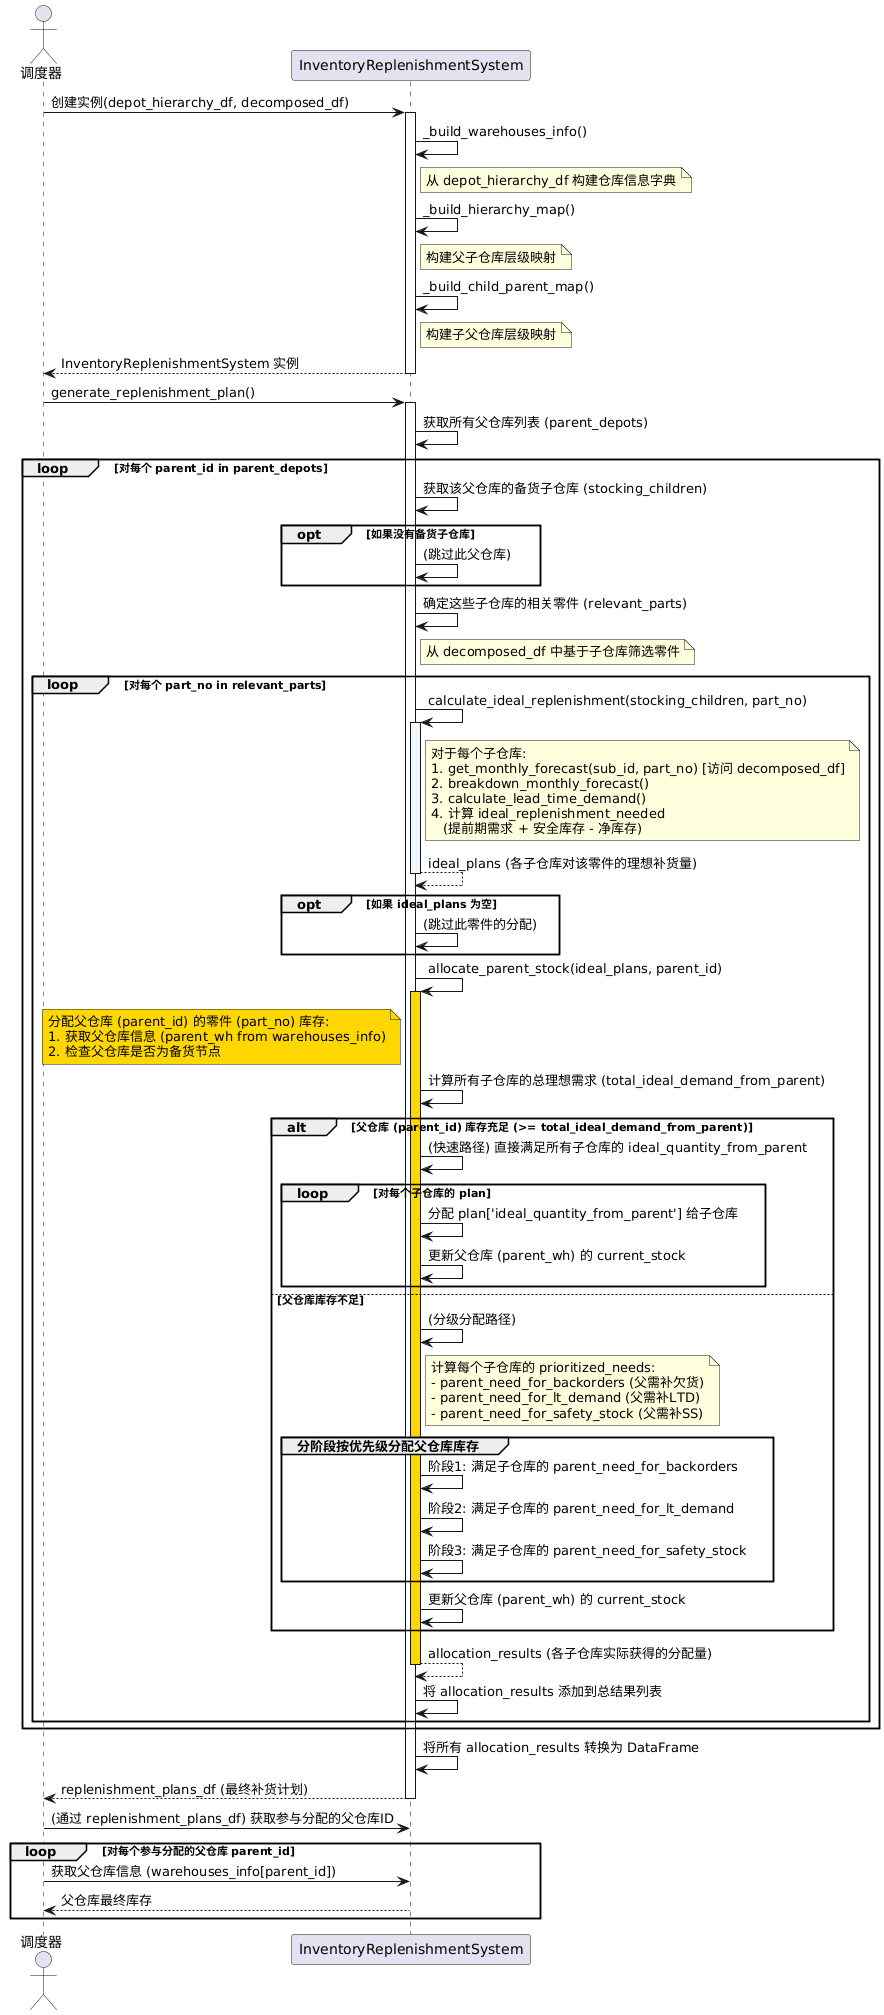

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from collections import defaultdict
import math
from dataclasses import dataclass, field
from typing import Dict

# Define the Warehouse dataclass
@dataclass
class Warehouse:
    id: str
    parent: str
    current_stock: int
    safety_stock: int  # Moved before default arguments
    lead_time: int     # Moved before default arguments
    min_order_qty: int # Moved before default arguments
    stocking_node: bool# Moved before default arguments
    in_transit: Dict[int, int] = field(default_factory=dict) # Default argument
    backorders: int = 0  # Default argument


class InventoryReplenishmentSystem:
    def __init__(self, depot_hierarchy_df, decomposed_df):
        self.depot_hierarchy_df = depot_hierarchy_df
        self.decomposed_df = decomposed_df
        self.today = datetime.now().date()
        self.days_in_month = 30  # Assuming 30 days per month
        self.warehouses_info = self._build_warehouses_info()
        self.parent_child_map = self._build_hierarchy_map()
        self.child_parent_map = self._build_child_parent_map()

    def _build_warehouses_info(self):
        warehouses = {}
        for _, row in self.depot_hierarchy_df.iterrows():
            in_transit_data = row.get('in_transit', {})
            if pd.isna(in_transit_data) or not isinstance(in_transit_data, dict):
                in_transit_data = {}

            backorders_data = row.get('backorders', 0)
            if pd.isna(backorders_data):
                backorders_data = 0

            warehouses[row['Depot']] = {
                'id': row['Depot'],
                'parent': row['ParentDepot'],
                'current_stock': row['current_stock'],
                'in_transit': in_transit_data,
                'safety_stock': row['safety_stock'],
                'lead_time': row['lead_time'],
                'min_order_qty': row['min_order_qty'],
                'stocking_node': (row['Stockiong'] == 'Y'), # Ensure this column name matches
                'backorders': backorders_data
            }
        return warehouses

    def _build_hierarchy_map(self):
        parent_to_children = defaultdict(list)
        for depot, info in self.warehouses_info.items():
            if info['parent'] and pd.notna(info['parent']): # Check for NaN parent
                parent_to_children[info['parent']].append(depot)
        return parent_to_children

    def _build_child_parent_map(self):
        child_to_parent = {}
        for depot, info in self.warehouses_info.items():
            if info['parent'] and pd.notna(info['parent']): # Check for NaN parent
                child_to_parent[depot] = info['parent']
        return child_to_parent

    def get_children(self, wh_name):
        return self.parent_child_map.get(wh_name, [])

    def get_monthly_forecast(self, depot_id, part_no):
        forecasts_df = self.decomposed_df[
            (self.decomposed_df['库房'] == depot_id) &
            (self.decomposed_df['零件号'] == part_no)
        ].sort_values(by='预测年月')
        forecasts = forecasts_df['预测值'].tolist()
        return forecasts + [0] * (6 - len(forecasts))

    def breakdown_monthly_forecast(self, monthly_forecast_value):
        daily_forecast = monthly_forecast_value / self.days_in_month if self.days_in_month > 0 else 0
        return [daily_forecast] * self.days_in_month

    def calculate_lead_time_demand(self, daily_forecasts, lead_time_days):
        effective_lead_time = min(int(lead_time_days), len(daily_forecasts))
        return sum(daily_forecasts[:effective_lead_time])

    def calculate_ideal_replenishment(self, sub_warehouses_list, part_no):
        replenishment_plans = []

        current_forecast_month_index = 0 # M0

        for sub_id in sub_warehouses_list:
            sub = self.warehouses_info.get(sub_id)
            if sub is None:
                print(f"Warning: Sub-warehouse {sub_id} not found in warehouses_info.")
                continue

            monthly_forecast_list = self.get_monthly_forecast(sub_id, part_no)
            if not monthly_forecast_list:
                 print(f"Warning: No forecast data found for {part_no} at {sub_id}. Skipping ideal calculation.")
                 continue

            # Get forecast for the current month (M0)
            current_month_forecast = monthly_forecast_list[current_forecast_month_index]

            lead_time_days = sub['lead_time'] * self.days_in_month
            # Breakdown the forecast for the current month (M0) into daily for LT demand calculation
            daily_forecasts_current_month = self.breakdown_monthly_forecast(current_month_forecast)

            # Calculate demand within the lead time based on daily forecasts
            # This calculation should potentially use future daily forecasts if LT > current month.
            # A more robust approach would calculate demand over the actual lead time period.
            # For simplicity here, let's assume the current month's daily rate is indicative,
            # but acknowledging this is a simplification for multi-month lead times.
            # A better approach would sum daily forecasts from the start of the lead time horizon.
            # Let's stick to the original intent of using daily forecast within lead time days for simplicity.
            lead_time_demand = self.calculate_lead_time_demand(daily_forecasts_current_month, lead_time_days)

            # Get in-transit quantity arriving in the current month (Month 0)
            # The in_transit dictionary keys should represent the month index relative to the current forecast start (0, 1, 2...)
            in_transit_current_month = sub['in_transit'].get(current_forecast_month_index, 0)
            # print(f"Debug: Sub {sub_id}, In-transit in M{current_forecast_month_index}: {in_transit_current_month}")


            # but for immediate allocation from parent, this net stock is what the child has on hand.
            # Include in-transit stock arriving in the current month in the net stock calculation.
            net_stock = sub['current_stock'] - sub['backorders'] + in_transit_current_month # FIX: Use the integer value

            # Ideal replenishment aims to cover LT demand + Safety Stock, considering current net stock.
            # This is the quantity the sub-warehouse *wishes to receive* from the parent.
            # The ideal quantity needed is to bring the stock up to a level that can cover Lead Time Demand + Safety Stock
            ideal_replenishment_needed = max(0, math.ceil(lead_time_demand + sub['safety_stock'] - net_stock))
            # print(f"Debug: Sub {sub_id}, Current Stock: {sub['current_stock']}, Backorders: {sub['backorders']}, In-transit M0: {in_transit_current_month}, Net Stock: {net_stock}, LT Demand: {math.ceil(lead_time_demand)}, Safety Stock: {sub['safety_stock']}, Ideal Needed: {ideal_replenishment_needed}")

            plan = {
                'sub_warehouse_id': sub['id'],
                'part_no': part_no,
                'backorders': sub['backorders'], # Child's own backorders
                'lead_time_demand': math.ceil(lead_time_demand), # Child's LT demand
                'safety_stock_target': sub['safety_stock'], # Child's SS target
                'ideal_quantity_from_parent': ideal_replenishment_needed, # This is the key "ideal" value
                'actual_quantity': 0,
                'lead_time_months': sub['lead_time']
            }
            replenishment_plans.append(plan)
        return replenishment_plans

    def allocate_parent_stock(self, ideal_replenishment_plans, parent_id):
        """
        根据父库房库存和子库房需求分配库存。
        如果父库房库存充足，则满足所有子库房的理想补货量。
        否则，按优先级（欠货 > 提前期需求 > 安全库存）分配。
        """
        parent_wh = self.warehouses_info.get(parent_id)
        if parent_wh is None:
            print(f"Error: Parent warehouse {parent_id} not found.")
            return []

        # Ensure ideal_replenishment_plans is not None and not empty
        if not ideal_replenishment_plans:
            # print(f"No ideal replenishment plans provided for parent {parent_id}.")
            return []


        # Get part number from the first plan (assuming all plans are for the same part)
        part_no = ideal_replenishment_plans[0].get('part_no', 'UNKNOWN_PART')
        print(f"\n--- 开始分配来自父库房 ({parent_id}) 的库存 ({part_no}) ---")

        # Make a deep copy of the plans to modify them for allocation
        # The 'ideal_quantity_from_parent' is what we work with.
        allocation_plans = [plan.copy() for plan in ideal_replenishment_plans]

        # Available stock from parent for allocation
        # We use a temporary variable for allocation simulation,
        # and only update the actual parent stock at the end.
        parent_available_stock = parent_wh['current_stock']
        print(f"父库房 ({parent_id}) 初始可用库存: {parent_available_stock}")

        if not parent_wh.get('stocking_node', False):
            print(f"Warning: Parent warehouse {parent_id} is not a stocking node. No stock to allocate.")
            # All 'actual_quantity' will remain 0, which is correct.
            return allocation_plans # Return plans with 0 allocated

        # --- NEW LOGIC: Fast Path for Sufficient Stock ---
        total_ideal_demand_from_parent = sum(plan['ideal_quantity_from_parent'] for plan in allocation_plans)
        print(f"所有子库房向父库房 ({parent_id}) 的总理想需求量: {total_ideal_demand_from_parent}")

        if parent_available_stock >= total_ideal_demand_from_parent:
            print(f"父库房 ({parent_id}) 库存充足，直接满足所有子库房的理想需求。")
            for plan in allocation_plans:
                amount_to_allocate = plan['ideal_quantity_from_parent']
                plan['actual_quantity'] = amount_to_allocate
                parent_available_stock -= amount_to_allocate
                print(f"  为子库房 {plan['sub_warehouse_id']} 分配其理想数量: {amount_to_allocate} 件")

            parent_wh['current_stock'] = parent_available_stock # Update actual parent stock
            print(f"父库房 ({parent_id}) 分配后剩余库存: {parent_available_stock}")
            print(f"--- 分配完成 (快速路径) ---")
            return allocation_plans
        else:
            # --- EXISTING LOGIC: Prioritized Allocation for Insufficient Stock ---
            print(f"父库房 ({parent_id}) 库存不足 ({parent_available_stock}) 以满足总理想需求 ({total_ideal_demand_from_parent}). 执行分级分配。")

            # Prepare detailed needs for prioritized allocation
            # These 'needs' are what the parent must supply if the child's own stock is insufficient.
            prioritized_needs = []
            for plan in allocation_plans: # Use the copied allocation_plans
                sub_id = plan['sub_warehouse_id']
                sub_info = self.warehouses_info[sub_id] # Get fresh sub info for stock levels
                sub_initial_stock = sub_info['current_stock']

                # Original child's metrics from the ideal plan
                sub_backorders = plan['backorders']
                sub_lt_demand_target = plan['lead_time_demand'] # This is the target coverage for LT
                sub_ss_target = plan['safety_stock_target']

                # Need from parent for backorders (if child's stock can't cover its own backorders)
                need_parent_for_backorders = max(0, sub_backorders - sub_initial_stock)

                # Stock remaining in child after covering its own backorders (conceptually)
                stock_after_child_covers_bo = max(0, sub_initial_stock - sub_backorders)

                # Need from parent for LT demand (if child's remaining stock can't cover LT demand)
                need_parent_for_lt_demand = max(0, sub_lt_demand_target - stock_after_child_covers_bo)

                # Stock remaining in child after covering its own BO and LT demand (conceptually)
                stock_after_child_covers_bo_ltd = max(0, stock_after_child_covers_bo - sub_lt_demand_target)

                # Need from parent for Safety Stock
                need_parent_for_safety_stock = max(0, sub_ss_target - stock_after_child_covers_bo_ltd)

                prioritized_needs.append({
                    'sub_warehouse_id': sub_id,
                    'part_no': part_no, # Already available from plan
                    'parent_need_backorders': need_parent_for_backorders,
                    'parent_need_lead_time': need_parent_for_lt_demand,
                    'parent_need_safety_stock': need_parent_for_safety_stock,
                    'actual_quantity': 0, # This will accumulate allocations from parent
                    # Carry over original plan details for reference if needed later
                    'original_ideal_quantity_from_parent': plan['ideal_quantity_from_parent'],
                    'original_backorders': plan['backorders'],
                    'original_lead_time_demand': plan['lead_time_demand'],
                    'original_safety_stock_target': plan['safety_stock_target'],
                    'lead_time_months': plan['lead_time_months']
                })

            # Pass 1: Allocate to cover Parent Need for Backorders
            print("分配阶段 1: 满足子库房欠货 (由父库房补充)")
            for need_plan in prioritized_needs:
                if parent_available_stock <= 0: break
                allocation = min(need_plan['parent_need_backorders'], parent_available_stock)
                need_plan['actual_quantity'] += allocation
                parent_available_stock -= allocation
                print(f"  为子库房 {need_plan['sub_warehouse_id']} 分配 {allocation} 件以补充其欠货")
            print(f"满足欠货补充后，父库房剩余库存: {parent_available_stock}")

            # Pass 2: Allocate to cover Parent Need for Lead Time Demand
            print("分配阶段 2: 满足子库房提前期需求 (由父库房补充)")
            for need_plan in prioritized_needs:
                if parent_available_stock <= 0: break
                # Amount still needed for LT for this child, considering what was already given for BO
                # The 'parent_need_lead_time' already accounts for child's stock.
                # We just need to ensure we don't double-allocate if parent_need_backorders was large.
                # The actual_quantity accumulates.
                needed_for_lt = need_plan['parent_need_lead_time']

                # This check is subtle: if parent_need_backorders fully covered this,
                # we don't want to allocate again.
                # However, parent_need_lead_time is calculated *after* conceptual BO coverage.
                # So, this should be fine.

                allocation = min(needed_for_lt, parent_available_stock)
                need_plan['actual_quantity'] += allocation
                parent_available_stock -= allocation
                print(f"  为子库房 {need_plan['sub_warehouse_id']} 分配 {allocation} 件以补充其提前期需求")
            print(f"满足提前期需求补充后，父库房剩余库存: {parent_available_stock}")

            # Pass 3: Allocate to cover Parent Need for Safety Stock
            print("分配阶段 3: 满足子库房安全库存 (由父库房补充)")
            for need_plan in prioritized_needs:
                if parent_available_stock <= 0: break
                needed_for_ss = need_plan['parent_need_safety_stock']
                allocation = min(needed_for_ss, parent_available_stock)
                need_plan['actual_quantity'] += allocation
                parent_available_stock -= allocation
                print(f"  为子库房 {need_plan['sub_warehouse_id']} 分配 {allocation} 件以补充其安全库存")
            print(f"满足安全库存补充后，父库房剩余库存: {parent_available_stock}")

            parent_wh['current_stock'] = parent_available_stock # Update actual parent stock
            print(f"--- 分配完成 (分级路径) ---")

            # Map results from prioritized_needs back to a format similar to ideal_replenishment_plans
            # The prioritized_needs list now contains the 'actual_quantity' based on shortage logic.
            # We need to ensure the returned structure is consistent.
            final_allocation_plans = []
            # We need to find the original ideal_plan to copy other fields if necessary, or just use what's in p_need
            # A bit complex if order changes, safer to rebuild from prioritized_needs
            for p_need in prioritized_needs:
                # Find the original plan to copy other fields if necessary, or just use what's in p_need
                original_plan_ref = next((p for p in allocation_plans if p['sub_warehouse_id'] == p_need['sub_warehouse_id']), None)
                if original_plan_ref:
                    plan_to_return = original_plan_ref.copy()
                    plan_to_return['actual_quantity'] = p_need['actual_quantity']
                    # Add the breakdown of needs for clarity if desired
                    plan_to_return['parent_supplied_for_backorders'] = min(p_need['parent_need_backorders'], p_need['actual_quantity'])
                    qty_after_bo = p_need['actual_quantity'] - plan_to_return['parent_supplied_for_backorders']
                    plan_to_return['parent_supplied_for_lead_time'] = min(p_need['parent_need_lead_time'], qty_after_bo)
                    qty_after_lt = qty_after_bo - plan_to_return['parent_supplied_for_lead_time']
                    plan_to_return['parent_supplied_for_safety_stock'] = min(p_need['parent_need_safety_stock'], qty_after_lt)

                    final_allocation_plans.append(plan_to_return)
                else: # Should not happen if logic is correct
                    p_need_copy = p_need.copy() # Fallback, might miss some original fields
                    final_allocation_plans.append(p_need_copy)

            return final_allocation_plans


    def generate_replenishment_plan(self):
        all_allocation_results = []
        parent_depots = [depot for depot, children in self.parent_child_map.items() if children]

        for parent_id in parent_depots:
            stocking_children = [
                child_id for child_id in self.get_children(parent_id)
                if self.warehouses_info.get(child_id, {}).get('stocking_node', False)
            ]
            if not stocking_children:
                # print(f"Parent depot {parent_id} has no stocking children to replenish.")
                continue

            # Determine relevant parts for these children
            # Ensure decomposed_df has '库房' and '零件号'
            if '库房' not in self.decomposed_df.columns or '零件号' not in self.decomposed_df.columns:
                print("Warning: decomposed_df missing '库房' or '零件号'. Cannot determine parts for replenishment.")
                continue

            relevant_parts_df = self.decomposed_df[self.decomposed_df['库房'].isin(stocking_children)]
            if relevant_parts_df.empty:
                # print(f"No forecast data in decomposed_df for stocking children of {parent_id}.")
                continue
            relevant_parts = relevant_parts_df['零件号'].unique().tolist()


            if not relevant_parts:
                # print(f"No relevant parts found for stocking children of {parent_id}.")
                continue

            for part_no in relevant_parts:
                ideal_plans = self.calculate_ideal_replenishment(stocking_children, part_no)
                if not ideal_plans:
                    # print(f"No ideal plans generated for {part_no} under parent {parent_id}.")
                    continue

                allocation_results = self.allocate_parent_stock(ideal_plans, parent_id)
                all_allocation_results.extend(allocation_results)

        if not all_allocation_results:
            print("No allocation results generated.")
            return pd.DataFrame() # Return empty DataFrame

        replenishment_plans_df = pd.DataFrame(all_allocation_results)

        if not replenishment_plans_df.empty:
            replenishment_plans_df['parent_warehouse_id'] = replenishment_plans_df['sub_warehouse_id'].map(self.child_parent_map)
        else:
            # If it's empty, ensure columns exist for consistency, or handle downstream
            # For now, just returning it as is.
            pass

        return replenishment_plans_df

# --- Example Usage (assuming depot_hierarchy_df and decomposed_df are loaded) ---

depot_hierarchy_df['in_transit'] = depot_hierarchy_df['in_transit'].apply(lambda x: x if isinstance(x, dict) else {})


# # --- Execution (assuming depot_hierarchy_df and decomposed_df are defined) ---
if 'depot_hierarchy_df' not in globals() or 'decomposed_df' not in globals():
  print("Please ensure depot_hierarchy_df and decomposed_df are loaded before running.")
else:
  # Validate required columns
  required_depot_cols = ['Depot', 'ParentDepot', 'current_stock', 'in_transit', 'safety_stock', 'lead_time', 'min_order_qty', 'Stockiong', 'backorders']
  if not all(col in depot_hierarchy_df.columns for col in required_depot_cols):
    print(f"Error: depot_hierarchy_df is missing one or more required columns: {required_depot_cols}")
  elif not all(col in decomposed_df.columns for col in ['库房', '零件号', '预测年月', '预测值']):
    print("Error: decomposed_df is missing one or more required columns: ['库房', '零件号', '预测年月', '预测值']")
  else:
    inventory_system = InventoryReplenishmentSystem(depot_hierarchy_df, decomposed_df)
    replenishment_plans_df = inventory_system.generate_replenishment_plan()

    print("\n===== 生成的分库补货计划 =====")
    if not replenishment_plans_df.empty:
      print(replenishment_plans_df.to_string())
    else:
      print("没有生成补货计划。")

print("\n===== 库房最终库存概览 (仅显示参与分配的父库房) =====")
if not replenishment_plans_df.empty and 'parent_warehouse_id' in replenishment_plans_df.columns:
  parent_ids_allocated_from = replenishment_plans_df['parent_warehouse_id'].dropna().unique()
  for parent_id in parent_ids_allocated_from:
    parent_wh_info = inventory_system.warehouses_info.get(parent_id)
    if parent_wh_info:
      print(f"库房: {parent_id}, 最终库存: {round(parent_wh_info['current_stock'])}")
    else:
      print("没有执行分配，或无法确定父库房。")